Import Libraries

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation
from skimage.measure import label, regionprops
from skimage import io, exposure
from skimage import measure
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import re
model_cellpose = models.Cellpose(model_type='cyto')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from huggingface_hub import hf_hub_download


from torch_em.util.util import get_random_colors
from torch_em.data.datasets.electron_microscopy.lucchi import get_lucchi_paths
from torch_em.data.datasets.light_microscopy.covid_if import get_covid_if_data

from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

from concurrent.futures import ThreadPoolExecutor, as_completed

In [18]:
MODEL_TYPE   = "vit_b_lm"
CHECKPOINT = hf_hub_download(repo_id="sunny17347/machine_learning_models", filename="SAM_finetuned.pt")
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.mkldnn.enabled = False

Define Sub Functions

In [19]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()
    
def display_two_images(image1, image2, title1, title2, path):
    """Display two images side-by-side with smaller title font."""
    filename = os.path.basename(path)  # Extract final part of path

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1, cmap='gray' if image1.ndim == 2 else None)
    axes[0].set_title(f"{filename} {title1}", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(image2, cmap='gray' if image2.ndim == 2 else None)
    axes[1].set_title(f"{filename} {title2}", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def size_threshold(image):
    """Remove small objects from the image."""
    return remove_small_objects(image, min_size=30)


def extract_channels(image):
    return image[0], image[1], image[2]

def analyze_image_c12(c12):
    contrast_adjusted_c12_normalized = (c12 - c12.min()) / (c12.max() - c12.min())
    threshold_value_c12 = np.mean(contrast_adjusted_c12_normalized) + (np.std(contrast_adjusted_c12_normalized) * 2) #1.75 works well
    c12_thresholded = contrast_adjusted_c12_normalized > threshold_value_c12
    c12_thresholded = remove_small_objects(c12_thresholded, min_size=10)
    labled_image = label(c12_thresholded)
    return c12_thresholded

def analyze_image_deep_red(deep_red):
    contrast_adjusted_deep_red_normalized = (deep_red - deep_red.min()) / (deep_red.max() - deep_red.min())
    threshold_value_deep_red = np.mean(contrast_adjusted_deep_red_normalized) + (np.std(contrast_adjusted_deep_red_normalized) * 4) #1.75 works well
    deep_red_thresholded = contrast_adjusted_deep_red_normalized > threshold_value_deep_red
    deep_red_thresholded = remove_small_objects(deep_red_thresholded, min_size=10)
    labled_image = label(deep_red_thresholded)
    return deep_red_thresholded

def separate_touching_objects(deep_red_mask, c12_mask, verbose=False):
    deep_red_only = np.zeros_like(deep_red_mask, dtype=np.uint8)
    c12_only = np.zeros_like(c12_mask, dtype=np.uint8)

    labeled_red = label(deep_red_mask)
    labeled_c12 = label(c12_mask)

    # Create full mask maps for checking overlap
    red_object_map = labeled_red > 0
    c12_object_map = labeled_c12 > 0

    # Track red objects that do NOT overlap any c12
    for region in regionprops(labeled_red):
        mask = labeled_red == region.label
        if np.any(mask & c12_object_map):
            continue
        else:
            deep_red_only += mask

    # Track c12 objects that do NOT overlap any deep red
    for region in regionprops(labeled_c12):
        mask = labeled_c12 == region.label
        if np.any(mask & red_object_map):
            continue
        else:
            c12_only += mask

    return deep_red_only, c12_only
def preprocess_green_channel(green_channel):
    """
    Preprocess the green fluorescence channel for better segmentation and inclusion detection.
    - Applies Gaussian blur to reduce noise.
    - Enhances contrast using sigmoid adjustment.
    - Normalizes intensities to [0, 1] for consistent processing.
    """
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = normalize_image(confocal_img)
    return confocal_img

def calculate_surface_area(labeled_image):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)


def circularity_index(mask):
    regions = measure.regionprops(label(mask))

    # Create empty masks to store the results
    clustered_lds = np.zeros_like(mask, dtype=bool)
    single_lds = np.zeros_like(mask, dtype=bool)

    # Iterate through regions and calculate circularity
    for region in regions:
        area = region.area
        perimeter = measure.perimeter(region.image)
        
        # Avoid division by zero
        if perimeter == 0 or area <= 10:
            continue
        
        circularity = (4 * np.pi * area) / (perimeter ** 2)
        
        # Assign region to the appropriate mask based on circularity
        if circularity < 0.8:
            # Mask for clustered regions
            clustered_lds[region.coords[:, 0], region.coords[:, 1]] = 1
        else:
            # Mask for non-clustered regions
            single_lds[region.coords[:, 0], region.coords[:, 1]] = 1
    
    clustered_lds = clustered_lds.astype(bool)
    single_lds = single_lds.astype(bool)

    return clustered_lds, single_lds

def normalize_image(image):
    """
    Normalize the image to the range [0, 1].
    This is useful for consistent processing across different images.
    """
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def segment_cells(green_channel):
    """
    Segment whole cells in the green channel using Cellpose.
    - Normalizes image intensity.
    - Suppresses bright spots (e.g., inclusions) to better detect cell boundaries.
    - Applies Gaussian blur for smoother segmentation input.
    - Gradually increases segmentation diameter until at least one cell is detected.
    """
    green_channel = normalize_image(green_channel)
    percentile_99 = np.percentile(green_channel, 99)
    
    # Suppress very bright pixels (inclusions)
    green_channel_remove_inclusions = np.where(green_channel < percentile_99, green_channel, percentile_99)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=5)

    # Normalize again after processing
    green_channel_remove_inclusions = normalize_image(green_channel_remove_inclusions)

    # Try different diameters until cells are detected
    diameter = 150
    while diameter < 500:
        masks, flows, styles, diams = model_cellpose.eval(green_channel_remove_inclusions, diameter=diameter, channels=[0, 0])
        labeled_cells = label(masks)
        if np.max(labeled_cells) > 0:
            return labeled_cells
        diameter += 25

    # No cells found
    return None

def find_surface_area(mask, path, i, inclusion_mask, type, category) -> int:
    if np.any(mask):
        mask = label(mask)
        surface_area = calculate_surface_area(mask)
        #display_image(mask, path, i+1)
        #print(f"Cell {i + 1} has a {surface_area} surface area of {type} {category}")
        #display_image(inclusion_mask, path, i+1)
        #print(f"Inclusion image of cell {i + 1} above")
    else:
        surface_area = 0
    return surface_area



def find_total_lds_and_surface_area(mask, path, i, type, category) -> int:
    if np.any(mask):
        mask_labeled = label(mask)
        surface_area = calculate_surface_area(mask_labeled)
        number_of_LDS = len(regionprops(mask_labeled))
        #display_image(mask_labeled, path, i+1)
        #print(f"Cell {i + 1} has {type} {number_of_LDS} {category}")
    else:
        surface_area = 0
        number_of_LDS = 0
    return surface_area, number_of_LDS

def seperate_LDS(inclusion_image, LDS_mask):
    LDS_in_inclusions = np.zeros_like(LDS_mask)
    LDS_in_cyto = np.zeros_like(LDS_mask)

    labled_LDS = label(LDS_mask)
    for i, region in enumerate(regionprops(labled_LDS)):
        mask = labled_LDS == region.label
        overlap = mask * inclusion_image
        if np.sum(overlap) > 0:
            LDS_in_inclusions += mask
        else:
            LDS_in_cyto += mask
    return LDS_in_inclusions, LDS_in_cyto

def find_all_data(applied_mask, total_mask, clustered_mask, single_mask, inclusions, path, i, category) -> int:
    LDS_in_cell = (applied_mask & total_mask)
    clustered_LDS_in_cell = (applied_mask & clustered_mask)
    single_LDS_in_cell = (applied_mask & single_mask)
    
    surface_area_LDS, number_of_LDS = find_total_lds_and_surface_area(LDS_in_cell, path, i, "total LDS", category) 
    surface_area_clustered_LDS, number_of_clustered_LDS = find_total_lds_and_surface_area(clustered_LDS_in_cell, path, i, "clustered LDS", category)  
    surface_area_single_LDS, number_of_single_LDS = find_total_lds_and_surface_area(single_LDS_in_cell, path, i, "single LDS", category)
        
    LDS_in_inclusion, LDS_not_in_inclusion = seperate_LDS(inclusions, LDS_in_cell)

    surface_area_LDS_in_inclusion, number_of_LDS_in_inclusion = find_total_lds_and_surface_area(LDS_in_inclusion, path, i, "LDS in inclusion", category)
    surface_area_LDS_not_in_inclusion, number_of_LDS_not_in_inclusion = find_total_lds_and_surface_area(LDS_not_in_inclusion, path, i, "LDS not in inclusion", category)

    total_clustered_LDS_in_inclusion, total_clustered_LDS_not_in_inclusion = seperate_LDS(inclusions, clustered_LDS_in_cell)

    surface_area_clustered_LDS_in_inclusion, number_of_clustered_LDS_in_inclusion = find_total_lds_and_surface_area(total_clustered_LDS_in_inclusion, path, i, "clustered LDS in inclusion", category)
    surface_area_clustered_LDS_not_in_inclusion, number_of_clustered_LDS_not_in_inclusion = find_total_lds_and_surface_area(total_clustered_LDS_not_in_inclusion, path, i, "clustered LDS not in inclusion", category)

    total_single_LDS_in_inclusion, total_single_LDS_not_in_inclusion = seperate_LDS(inclusions, single_LDS_in_cell)

    surface_area_single_LDS_in_inclusion, number_of_single_LDS_in_inclusion = find_total_lds_and_surface_area(total_single_LDS_in_inclusion, path, i, "single LDS in inclusion", category)
    surface_area_single_LDS_not_in_inclusion, number_of_single_LDS_not_in_inclusion = find_total_lds_and_surface_area(total_single_LDS_not_in_inclusion, path, i, "single LDS not in inclusion", category)


    return surface_area_LDS, number_of_LDS, surface_area_clustered_LDS, number_of_clustered_LDS, surface_area_single_LDS, number_of_single_LDS, surface_area_LDS_in_inclusion, surface_area_LDS_not_in_inclusion, surface_area_clustered_LDS_in_inclusion, surface_area_clustered_LDS_not_in_inclusion, surface_area_single_LDS_in_inclusion, surface_area_single_LDS_not_in_inclusion, number_of_LDS_in_inclusion, number_of_LDS_not_in_inclusion, number_of_clustered_LDS_in_inclusion, number_of_clustered_LDS_not_in_inclusion, number_of_single_LDS_in_inclusion, number_of_single_LDS_not_in_inclusion

def analysis(labeled_cells, path, red_total, c12_total, red_only, c12_only, inclusions_mask):
    
    cell_data = []

    filtered_cells = [cell for cell in regionprops(labeled_cells) if cell.area >= 50]

    clustered_c12_total, single_c12_total = circularity_index(c12_total)
    clustered_red_total, single_red_total = circularity_index(red_total)
    clustered_c12_only, single_c12_only = circularity_index(c12_only)
    clustered_red_only, single_red_only = circularity_index(red_only)

    for i, cell in enumerate(filtered_cells):
        mask = labeled_cells == cell.label
        


        inclusion_size = []
        inclusion_size_swiss = []
        inclusion_size_solid = []

        
        applied_mask = mask > 0  # Convert to boolean if not already
        red_total = red_total > 0  # Convert to boolean if not already
        c12_total = c12_total > 0  # Convert to boolean if not already
        red_only = red_only > 0  # Convert to boolean if not already
        c12_only = c12_only > 0  # Convert to boolean if not already
        inclusions_in_cell = inclusions_mask * mask
        inclusions_in_cell_labeled = label(inclusions_in_cell)

        
        total_surface_area_C12_LDS, total_C12_LDS, total_surface_area_clustered_C12_LDS, total_clustered_C12_LDS, total_surface_area_single_C12_LDS, total_single_C12_LDS, surface_area_C12_total_LDS_in_inclusion, surface_area_C12_total_LDS_not_in_inclusion, surface_area_clustered_C12_LDS_in_inclusion, surface_area_clustered_C12_LDS_not_in_inclusion, surface_area_single_C12_LDS_in_inclusion, surface_area_single_C12_LDS_not_in_inclusion, number_of_LDS_in_inclusion_all_c12, number_of_LDS_not_in_inclusion_all_c12, number_of_clustered_LDS_in_inclusion_all_c12, number_of_clustered_LDS_not_in_inclusion_all_c12, number_of_single_LDS_in_inclusion_all_c12, number_of_single_LDS_not_in_inclusion_all_c12 = find_all_data(applied_mask, c12_total, clustered_c12_total, single_c12_total, inclusions_in_cell, path, i, "total c12")
        
        total_surface_area_red_LDS, total_red_LDS, total_surface_area_clustered_red_LDS, total_clustered_red_LDS, total_surface_area_single_red_LDS, total_single_red_LDS, surface_area_total_red_LDS_in_inclusion, surface_area_total_red_LDS_not_in_inclusion, surface_area_clustered_red_LDS_in_inclusion, surface_area_clustered_red_LDS_not_in_inclusion, surface_area_single_red_LDS_in_inclusion, surface_area_single_red_LDS_not_in_inclusion, number_of_LDS_in_inclusion_all_red, number_of_LDS_not_in_inclusion_all_red, number_of_clustered_LDS_in_inclusion_all_red, number_of_clustered_LDS_not_in_inclusion_all_red, number_of_single_LDS_in_inclusion_all_red, number_of_single_LDS_not_in_inclusion_all_red = find_all_data(applied_mask, red_total, clustered_red_total, single_red_total, inclusions_in_cell, path, i, "total red")

        total_surface_area_red_LDS_only, total_red_LDS_only, total_surface_area_clustered_red_LDS_only, total_clustered_red_LDS_only, total_surface_area_single_red_LDS_only, total_single_red_LDS_only, surface_area_total_red_LDS_only_in_inclusion, surface_area_total_red_LDS_only_not_in_inclusion, surface_area_clustered_red_LDS_only_in_inclusion, surface_area_clustered_red_LDS_only_not_in_inclusion, surface_area_single_red_LDS_only_in_inclusion, surface_area_single_red_LDS_only_not_in_inclusion, number_of_LDS_in_inclusion_red_only, number_of_LDS_not_in_inclusion_red_only, number_of_clustered_LDS_in_inclusion_red_only, number_of_clustered_LDS_not_in_inclusion_red_only, number_of_single_LDS_in_inclusion_red_only, number_of_single_LDS_not_in_inclusion_red_only = find_all_data(applied_mask, red_only, clustered_red_only, single_red_only, inclusions_in_cell, path, i, "red only")

        total_surface_area_C12_LDS_only, total_C12_LDS_only, total_surface_area_clustered_C12_LDS_only, total_clustered_C12_LDS_only, total_surface_area_single_C12_LDS_only, total_single_C12_LDS_only, surface_area_total_C12_LDS_only_in_inclusion, surface_area_total_C12_LDS_only_not_in_inclusion, surface_area_clustered_C12_LDS_only_in_inclusion, surface_area_clustered_C12_LDS_only_not_in_inclusion, surface_area_single_C12_LDS_only_in_inclusion, surface_area_single_C12_LDS_only_not_in_inclusion, number_of_LDS_in_inclusion_c12_only, number_of_LDS_not_in_inclusion_c12_only, number_of_clustered_LDS_in_inclusion_c12_only, number_of_clustered_LDS_not_in_inclusion_c12_only, number_of_single_LDS_in_inclusion_c12_only, number_of_single_LDS_not_in_inclusion_c12_only = find_all_data(applied_mask, c12_only, clustered_c12_only, single_c12_only, inclusions_in_cell, path, i, "c12 only")


        for inclusion in regionprops(inclusions_in_cell_labeled):
            if inclusion.area > 0:
                inclusion_mask = inclusions_in_cell_labeled == inclusion.label
                LDS_in_inclusion = (inclusion_mask & red_total) | (inclusion_mask & c12_total)
                inclusion_size.append(inclusion.area)

                # Determine inclusion type based on lipid presence
                if np.any(LDS_in_inclusion):
                    inclusion_size_swiss.append(inclusion.area)
                    type = "swiss"
                else:
                    inclusion_size_solid.append(inclusion.area)
                    type = "solid"
                #print(f"{inclusion.area} {type} inclusion in cell {cell.label}")

        if not inclusion_size:
            cell_data.append({
                'Filename': path,
                'Cell Number': i + 1,
                'Cytoplasm Surface Area': cell.area,
                'Total Number of Inclusions': None,  # No inclusion number
                'Average Surface Area of all Inclusions': 0,  # No inclusion surface area
                'Number of Solid Inclusions': 0,
                'Average Surface Area of Solid Inclusions': 0,  # Average surface area of solid inclusions
                'Number of Swiss Inclusions': 0,
                'Average Surface Area of Swiss Inclusions': 0,  # Surface area of this inclusion
                'Number of all C12 Clumped LDS': total_clustered_C12_LDS,
                'Surface area of all C12 Clumped LDS': total_surface_area_clustered_C12_LDS,
                'Number of all C12 Clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_all_c12,
                'Surface area of all C12 Clumped LDS in inclusion': surface_area_clustered_C12_LDS_in_inclusion,
                'Number of all C12 Clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_all_c12,
                'Surface area of all C12 Clumped LDS not in inclusion': surface_area_clustered_C12_LDS_not_in_inclusion,
                'Number of all C12 Single LDS': total_single_C12_LDS,
                'Surface area of all C12 Single LDS': total_surface_area_single_C12_LDS,
                'Number of all C12 Single LDS in inclusion': number_of_single_LDS_in_inclusion_all_c12,
                'Surface area of all C12 Single LDS in inclusion': surface_area_single_C12_LDS_in_inclusion,
                'Number of all C12 Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_all_c12,
                'Surface area of all C12 Single LDS not in inclusion': surface_area_single_C12_LDS_not_in_inclusion,
                'Number of all C12 total LDS': total_C12_LDS,
                'Surface area of all C12 total LDS': total_surface_area_C12_LDS,
                'Number of all C12 total LDS in inclusion': number_of_LDS_in_inclusion_all_c12,
                'Surface area of all C12 total LDS in inclusion': surface_area_C12_total_LDS_in_inclusion,
                'Number of all C12 total LDS not in inclusion': number_of_LDS_not_in_inclusion_all_c12,
                'Surface area of all C12 total LDS not in inclusion': surface_area_C12_total_LDS_not_in_inclusion,
                'Number of all Red Clumped LDS': total_clustered_red_LDS,
                'Surface area of all Red Clumped LDS': total_surface_area_clustered_red_LDS,
                'Number of all Red Clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_all_red,
                'Surface area of all Red Clumped LDS in inclusion': surface_area_clustered_red_LDS_in_inclusion,
                'Number of all Red Clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_all_red,
                'Surface area of all Red Clumped LDS not in inclusion': surface_area_clustered_red_LDS_not_in_inclusion,
                'Number of all Red Single LDS': total_single_red_LDS,
                'Surface area of all Red Single LDS': total_surface_area_single_red_LDS,
                'Number of all Red Single LDS in inclusion': number_of_single_LDS_in_inclusion_all_red,
                'Surface area of all Red Single LDS in inclusion': surface_area_single_red_LDS_in_inclusion,
                'Number of all Red Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_all_red,
                'Surface area of all Red Single LDS not in inclusion': surface_area_single_red_LDS_not_in_inclusion,
                'Number of all Red Total LDS': total_red_LDS,
                'Surface area of all Red Total LDS': total_surface_area_red_LDS,
                'Number of all Red Total LDS in inclusion': number_of_LDS_in_inclusion_all_red,
                'Surface area of all Red Total LDS in inclusion': surface_area_total_red_LDS_in_inclusion,
                'Number of all Red Total LDS not in inclusion': number_of_LDS_not_in_inclusion_all_red,
                'Surface area of all Red Total LDS not in inclusion': surface_area_total_red_LDS_not_in_inclusion,
                'Number of C12-only clumped LDS': total_clustered_C12_LDS_only,
                'Surface area of C12-only clumped LDS': total_surface_area_clustered_C12_LDS_only,
                'Number of C12-only clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_c12_only,
                'Surface area of C12-only clumped LDS in inclusion': surface_area_clustered_C12_LDS_only_in_inclusion,
                'Number of C12-only clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_c12_only,
                'Surface area of C12-only clumped LDS not in inclusion': surface_area_clustered_C12_LDS_only_not_in_inclusion,
                'Number of C12-only Single LDS': total_single_C12_LDS_only,
                'Surface area of C12-only Single LDS': total_surface_area_single_C12_LDS_only,
                'Number of C12-only Single LDS in inclusion': number_of_single_LDS_in_inclusion_c12_only,
                'Surface area of C12-only Single LDS in inclusion': surface_area_single_C12_LDS_only_in_inclusion,
                'Number of C12-only Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_c12_only,
                'Surface area of C12-only Single LDS not in inclusion': surface_area_single_C12_LDS_only_not_in_inclusion,
                'Number of C12-only Total LDS': total_C12_LDS_only,
                'Surface area of C12-only Total LDS': total_surface_area_C12_LDS_only,
                'Number of C12-only Total LDS in inclusion': number_of_LDS_in_inclusion_c12_only,
                'Surface area of C12-only Total LDS in inclusion': surface_area_total_C12_LDS_only_in_inclusion,
                'Number of C12-only Total LDS not in inclusion': number_of_LDS_not_in_inclusion_c12_only,
                'Surface area of C12-only Total LDS not in inclusion': surface_area_total_C12_LDS_only_not_in_inclusion,
                'Number of Red-only Clumped LDS': total_clustered_red_LDS_only,
                'Surface area of Red-only Clumped LDS': total_surface_area_clustered_red_LDS_only,
                'Number of Red-only Clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_red_only,
                'Surface area of Red-only Clumped LDS in inclusion': surface_area_clustered_red_LDS_only_in_inclusion,
                'Number of Red-only Clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_red_only,
                'Surface area of Red-only Clumped LDS not in inclusion': surface_area_clustered_red_LDS_only_not_in_inclusion,
                'Number of Red-only Single LDS': total_single_red_LDS_only,
                'Surface area of Red-only Single LDS': total_surface_area_single_red_LDS_only,
                'Number of Red-only Single LDS in inclusion': number_of_single_LDS_in_inclusion_red_only,
                'Surface area of Red-only Single LDS in inclusion': surface_area_single_red_LDS_only_in_inclusion,
                'Number of Red-only Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_red_only,
                'Surface area of Red-only Single LDS not in inclusion': surface_area_single_red_LDS_only_not_in_inclusion,
                'Number of Red-only Total LDS': total_red_LDS_only,
                'Surface area of Red-only Total LDS': total_surface_area_red_LDS_only,
                'Number of Red-only Total LDS in inclusion': number_of_LDS_in_inclusion_red_only,
                'Surface area of Red-only Total LDS in inclusion': surface_area_total_red_LDS_only_in_inclusion,
                'Number of Red-only Total LDS not in inclusion': number_of_LDS_not_in_inclusion_red_only,
                'Surface area of Red-only Total LDS not in inclusion': surface_area_total_red_LDS_only_not_in_inclusion,
                'Red-only total/all red total (in inclusion)': number_of_LDS_in_inclusion_red_only / number_of_LDS_in_inclusion_all_red if number_of_LDS_in_inclusion_all_red > 0 else 0,
                'Red-only total/all red total (outside inclusion)': number_of_LDS_not_in_inclusion_red_only / number_of_LDS_not_in_inclusion_all_red if number_of_LDS_not_in_inclusion_all_red > 0 else 0,
            })
        else:
            total_inclusions = len(inclusion_size)  # Total number of inclusions
            average_surface_area = sum(inclusion_size) / total_inclusions  # Average surface area

            number_of_solid_inclusions = len(inclusion_size_solid)  

            if number_of_solid_inclusions == 0:
                average_surface_area_solid = 0
            else: 
                average_surface_area_solid = sum(inclusion_size_solid) / number_of_solid_inclusions

            number_of_swiss_inclusions = len(inclusion_size_swiss) 

            if number_of_swiss_inclusions == 0:
                average_surface_area_swiss = 0
            else:
                # Avoid division by zero for average surface area of swiss inclusions
                average_surface_area_swiss = sum(inclusion_size_swiss) / number_of_swiss_inclusions

            cell_data.append({
                'Filename': path,
                'Cell Number': i + 1,
                'Cytoplasm Surface Area': cell.area,
                'Total Number of Inclusions': total_inclusions, 
                'Average Surface Area of all Inclusions': average_surface_area,  # Average surface area of inclusions
                'Number of Solid Inclusions': number_of_solid_inclusions,
                'Average Surface Area of Solid Inclusions': average_surface_area_solid,  # Average surface area of solid inclusions
                'Number of Swiss Inclusions': number_of_swiss_inclusions,
                'Average Surface Area of Swiss Inclusions': average_surface_area_swiss,  # Surface area of this inclusion
                'Number of all C12 Clumped LDS': total_clustered_C12_LDS,
                'Surface area of all C12 Clumped LDS': total_surface_area_clustered_C12_LDS,
                'Number of all C12 Clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_all_c12,
                'Surface area of all C12 Clumped LDS in inclusion': surface_area_clustered_C12_LDS_in_inclusion,
                'Number of all C12 Clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_all_c12,
                'Surface area of all C12 Clumped LDS not in inclusion': surface_area_clustered_C12_LDS_not_in_inclusion,
                'Number of all C12 Single LDS': total_single_C12_LDS,
                'Surface area of all C12 Single LDS': total_surface_area_single_C12_LDS,
                'Number of all C12 Single LDS in inclusion': number_of_single_LDS_in_inclusion_all_c12,
                'Surface area of all C12 Single LDS in inclusion': surface_area_single_C12_LDS_in_inclusion,
                'Number of all C12 Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_all_c12,
                'Surface area of all C12 Single LDS not in inclusion': surface_area_single_C12_LDS_not_in_inclusion,
                'Number of all C12 total LDS': total_C12_LDS,
                'Surface area of all C12 total LDS': total_surface_area_C12_LDS,
                'Number of all C12 total LDS in inclusion': number_of_LDS_in_inclusion_all_c12,
                'Surface area of all C12 total LDS in inclusion': surface_area_C12_total_LDS_in_inclusion,
                'Number of all C12 total LDS not in inclusion': number_of_LDS_not_in_inclusion_all_c12,
                'Surface area of all C12 total LDS not in inclusion': surface_area_C12_total_LDS_not_in_inclusion,
                'Number of all Red Clumped LDS': total_clustered_red_LDS,
                'Surface area of all Red Clumped LDS': total_surface_area_clustered_red_LDS,
                'Number of all Red Clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_all_red,
                'Surface area of all Red Clumped LDS in inclusion': surface_area_clustered_red_LDS_in_inclusion,
                'Number of all Red Clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_all_red,
                'Surface area of all Red Clumped LDS not in inclusion': surface_area_clustered_red_LDS_not_in_inclusion,
                'Number of all Red Single LDS': total_single_red_LDS,
                'Surface area of all Red Single LDS': total_surface_area_single_red_LDS,
                'Number of all Red Single LDS in inclusion': number_of_single_LDS_in_inclusion_all_red,
                'Surface area of all Red Single LDS in inclusion': surface_area_single_red_LDS_in_inclusion,
                'Number of all Red Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_all_red,
                'Surface area of all Red Single LDS not in inclusion': surface_area_single_red_LDS_not_in_inclusion,
                'Number of all Red Total LDS': total_red_LDS,
                'Surface area of all Red Total LDS': total_surface_area_red_LDS,
                'Number of all Red Total LDS in inclusion': number_of_LDS_in_inclusion_all_red,
                'Surface area of all Red Total LDS in inclusion': surface_area_total_red_LDS_in_inclusion,
                'Number of all Red Total LDS not in inclusion': number_of_LDS_not_in_inclusion_all_red,
                'Surface area of all Red Total LDS not in inclusion': surface_area_total_red_LDS_not_in_inclusion,
                'Number of C12-only clumped LDS': total_clustered_C12_LDS_only,
                'Surface area of C12-only clumped LDS': total_surface_area_clustered_C12_LDS_only,
                'Number of C12-only clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_c12_only,
                'Surface area of C12-only clumped LDS in inclusion': surface_area_clustered_C12_LDS_only_in_inclusion,
                'Number of C12-only clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_c12_only,
                'Surface area of C12-only clumped LDS not in inclusion': surface_area_clustered_C12_LDS_only_not_in_inclusion,
                'Number of C12-only Single LDS': total_single_C12_LDS_only,
                'Surface area of C12-only Single LDS': total_surface_area_single_C12_LDS_only,
                'Number of C12-only Single LDS in inclusion': number_of_single_LDS_in_inclusion_c12_only,
                'Surface area of C12-only Single LDS in inclusion': surface_area_single_C12_LDS_only_in_inclusion,
                'Number of C12-only Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_c12_only,
                'Surface area of C12-only Single LDS not in inclusion': surface_area_single_C12_LDS_only_not_in_inclusion,
                'Number of C12-only Total LDS': total_C12_LDS_only,
                'Surface area of C12-only Total LDS': total_surface_area_C12_LDS_only,
                'Number of C12-only Total LDS in inclusion': number_of_LDS_in_inclusion_c12_only,
                'Surface area of C12-only Total LDS in inclusion': surface_area_total_C12_LDS_only_in_inclusion,
                'Number of C12-only Total LDS not in inclusion': number_of_LDS_not_in_inclusion_c12_only,
                'Surface area of C12-only Total LDS not in inclusion': surface_area_total_C12_LDS_only_not_in_inclusion,
                'Number of Red-only Clumped LDS': total_clustered_red_LDS_only,
                'Surface area of Red-only Clumped LDS': total_surface_area_clustered_red_LDS_only,
                'Number of Red-only Clumped LDS in inclusion': number_of_clustered_LDS_in_inclusion_red_only,
                'Surface area of Red-only Clumped LDS in inclusion': surface_area_clustered_red_LDS_only_in_inclusion,
                'Number of Red-only Clumped LDS not in inclusion': number_of_clustered_LDS_not_in_inclusion_red_only,
                'Surface area of Red-only Clumped LDS not in inclusion': surface_area_clustered_red_LDS_only_not_in_inclusion,
                'Number of Red-only Single LDS': total_single_red_LDS_only,
                'Surface area of Red-only Single LDS': total_surface_area_single_red_LDS_only,
                'Number of Red-only Single LDS in inclusion': number_of_single_LDS_in_inclusion_red_only,
                'Surface area of Red-only Single LDS in inclusion': surface_area_single_red_LDS_only_in_inclusion,
                'Number of Red-only Single LDS not in inclusion': number_of_single_LDS_not_in_inclusion_red_only,
                'Surface area of Red-only Single LDS not in inclusion': surface_area_single_red_LDS_only_not_in_inclusion,
                'Number of Red-only Total LDS': total_red_LDS_only,
                'Surface area of Red-only Total LDS': total_surface_area_red_LDS_only,
                'Number of Red-only Total LDS in inclusion': number_of_LDS_in_inclusion_red_only,
                'Surface area of Red-only Total LDS in inclusion': surface_area_total_red_LDS_only_in_inclusion,
                'Number of Red-only Total LDS not in inclusion': number_of_LDS_not_in_inclusion_red_only,
                'Surface area of Red-only Total LDS not in inclusion': surface_area_total_red_LDS_only_not_in_inclusion,
                'Red-only total/all red total (in inclusion)': number_of_LDS_in_inclusion_red_only / number_of_LDS_in_inclusion_all_red if number_of_LDS_in_inclusion_all_red > 0 else 0,
                'Red-only total/all red total (outside inclusion)': number_of_LDS_not_in_inclusion_red_only / number_of_LDS_not_in_inclusion_all_red if number_of_LDS_not_in_inclusion_all_red > 0 else 0,
            })
    df_cell_summary = pd.DataFrame(cell_data)

    return df_cell_summary

Main Function

→ Starting 021925_images/1K
→ Starting 021925_images/WT


c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_dataset.py:261: UserWarning: SegmentationDataset could not be deserialized because of missing full_data/images_uint8, *.png.
The dataset is deserialized in order to allow loading trained models from a checkpoint.
But it cannot be used for further training and will throw an error.
  warnings.warn(msg)
c:\Users\sj1205\AppData\Local\miniconda3\Lib\site-packages\torch_em\data\segmentation_dataset.py:274: UserWarning: SegmentationDataset could not be deserialized because of missing full_data/masks, *.png.
The dataset is deserialized in order to allow loading trained models from a checkpoint.
But it cannot be used for further training and will throw an error.
  warnings.warn(msg)


    Processing 021925_images/WT\WT_C12_DMEM_24h_LT_01.czi…
    Processing 021925_images/1K\1K_C12_DMEM_24h_LT_01.czi…


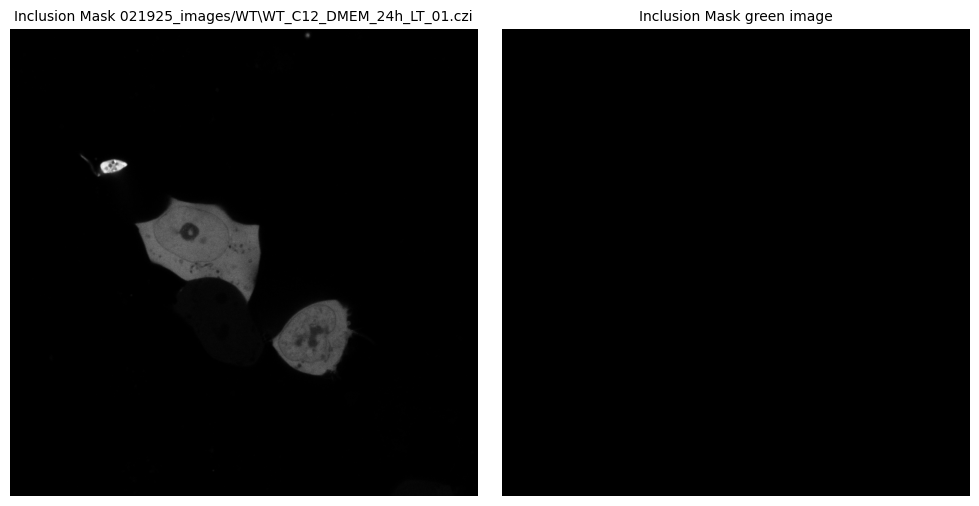

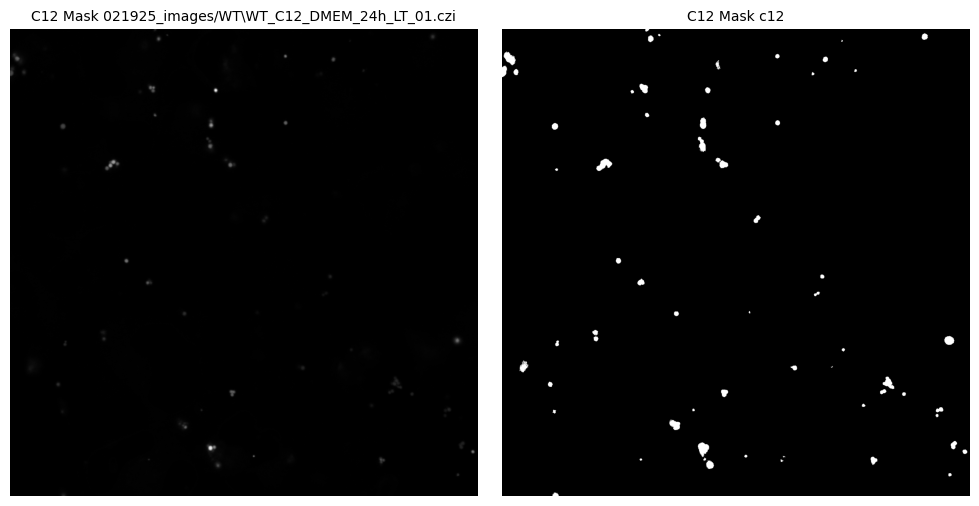

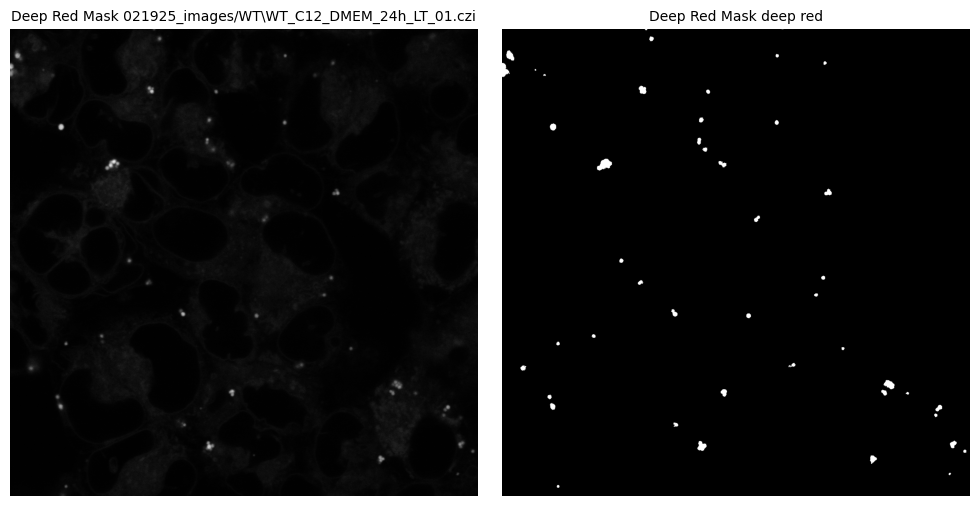

    Processing 021925_images/WT\WT_C12_DMEM_24h_LT_02.czi…


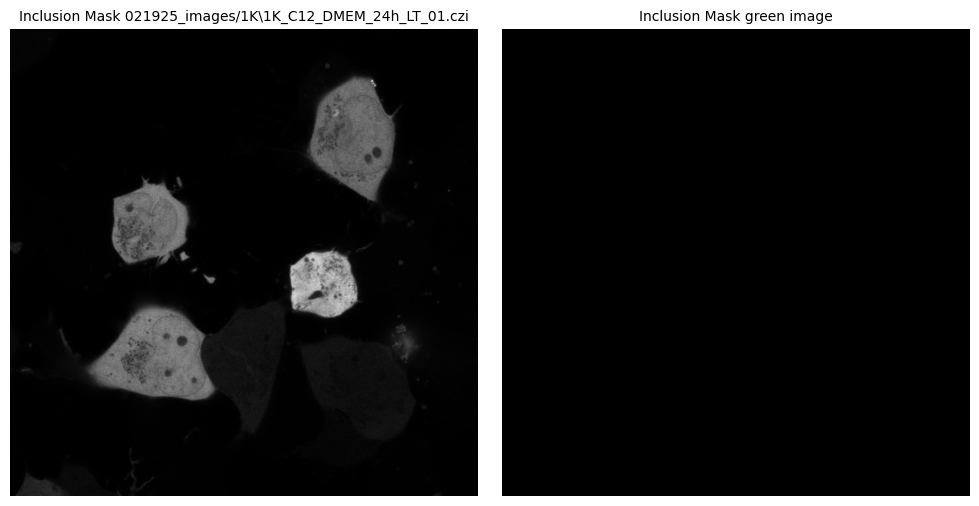

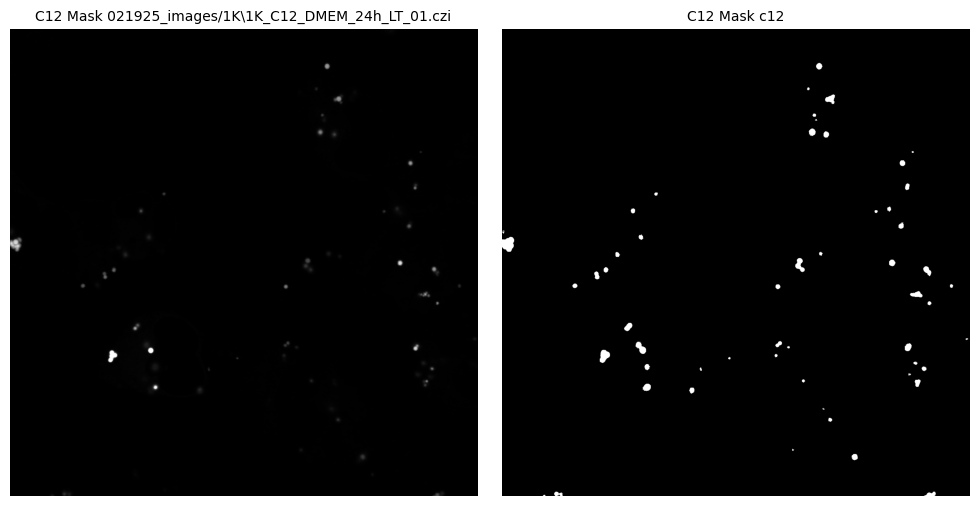

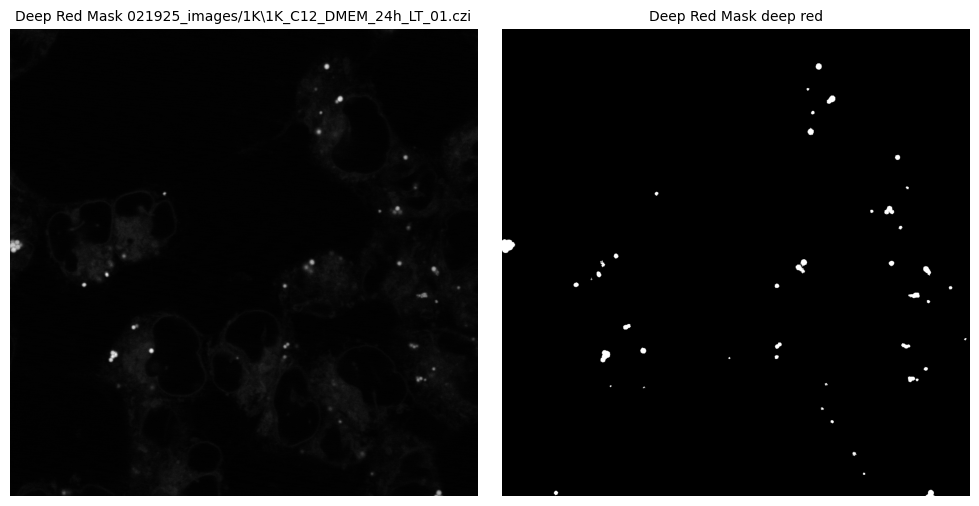

    Processing 021925_images/1K\1K_C12_DMEM_24h_LT_02.czi…


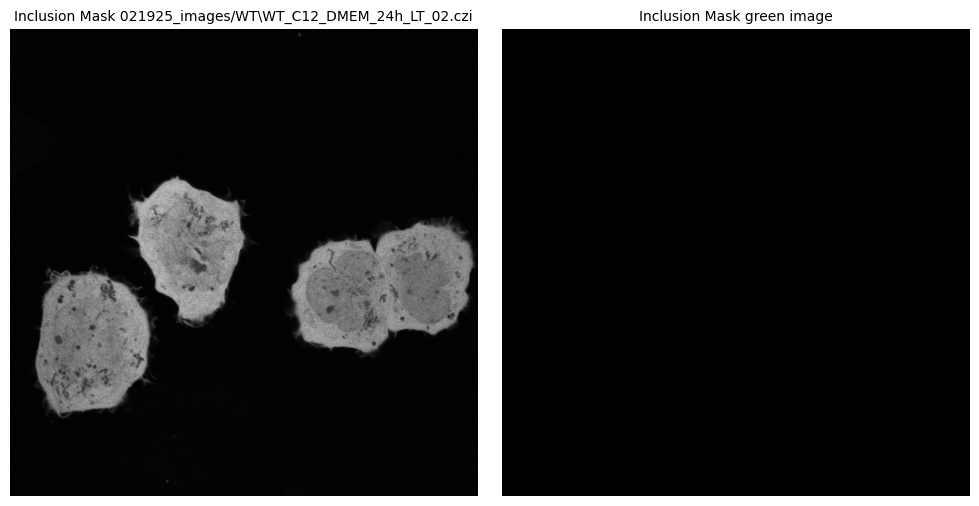

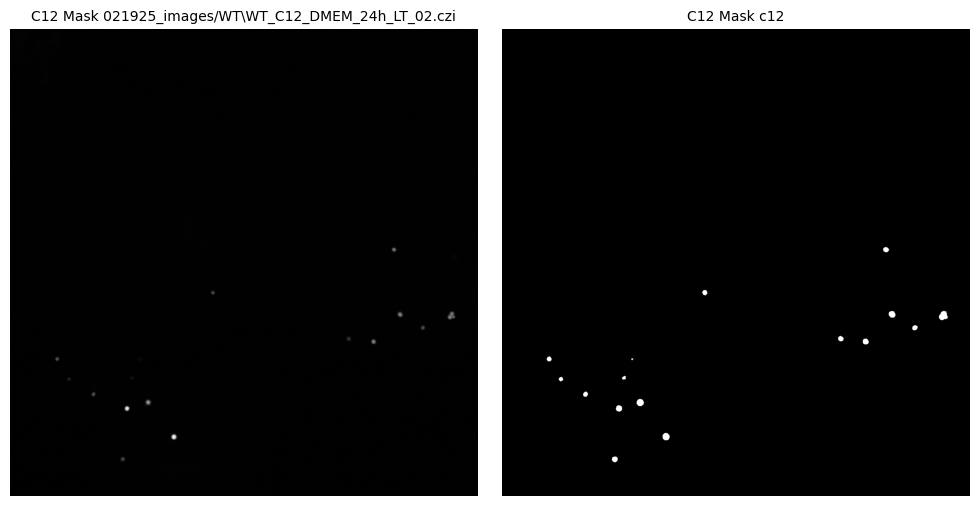

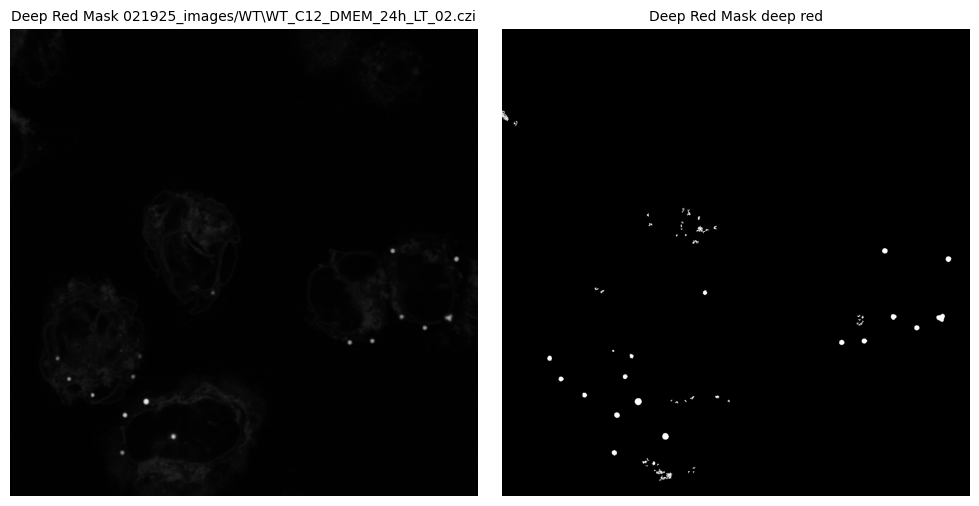

    Processing 021925_images/WT\WT_C12_DMEM_24h_LT_03.czi…


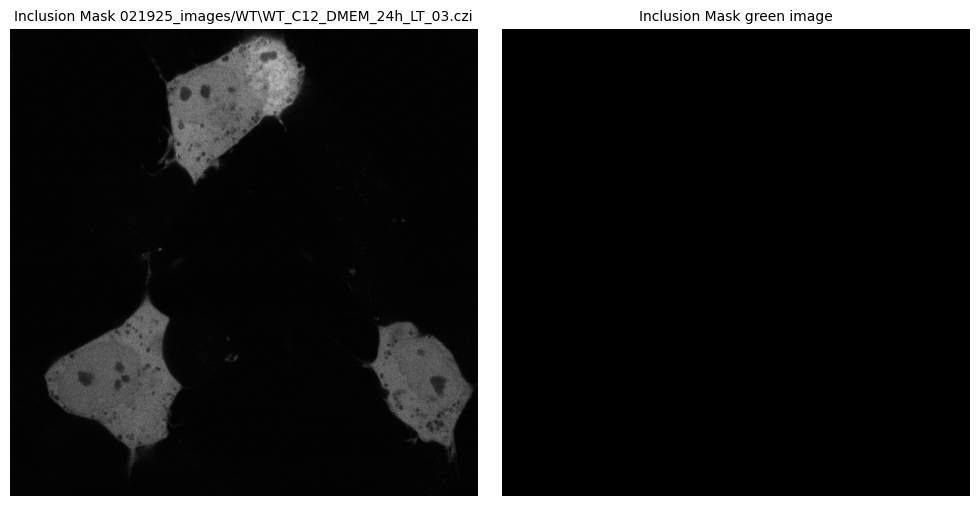

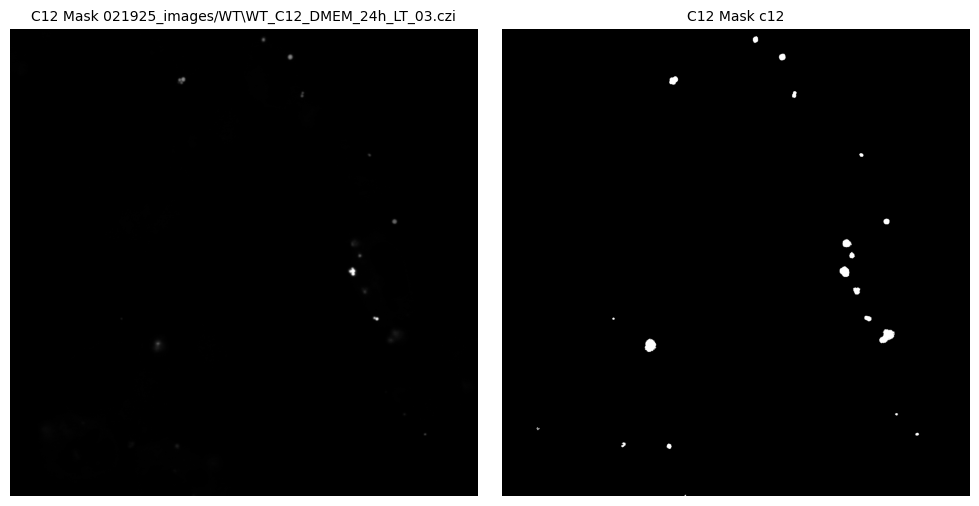

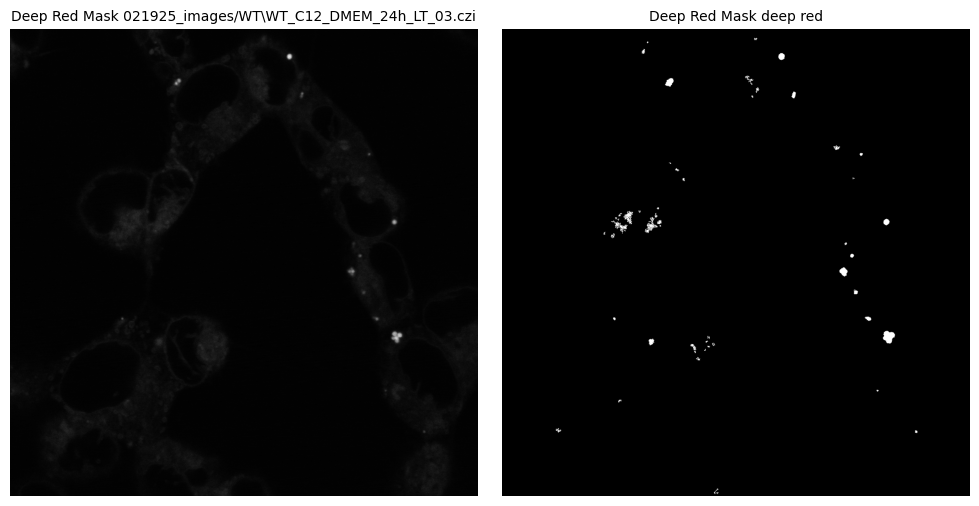

    Processing 021925_images/WT\WT_C12_DMEM_24h_LT_04.czi…


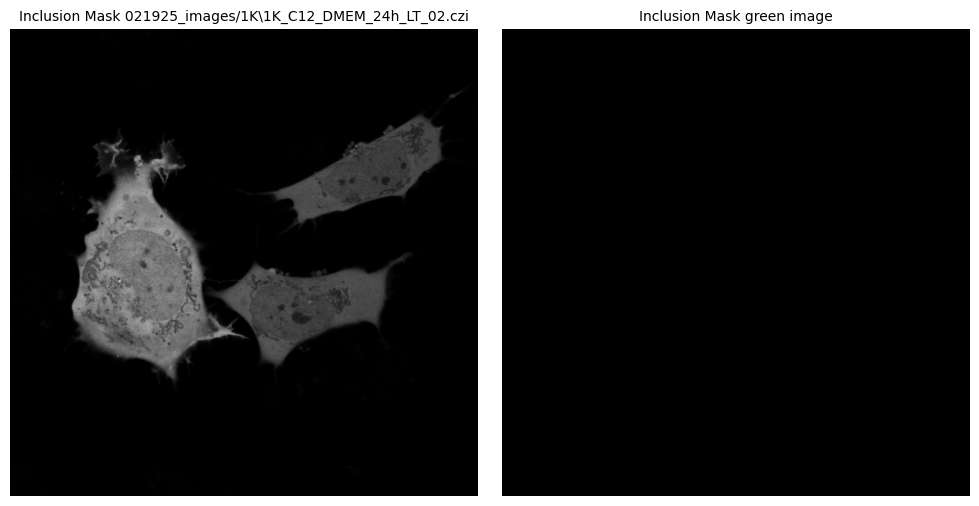

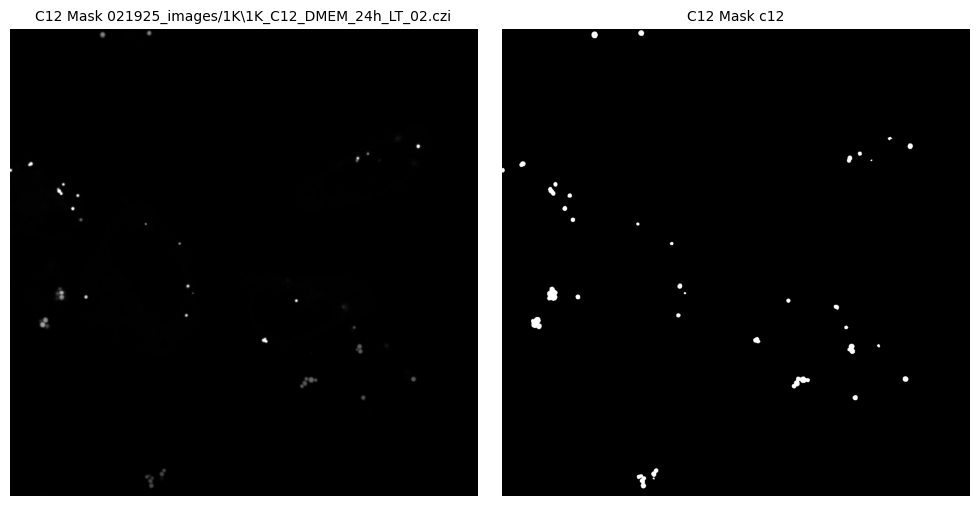

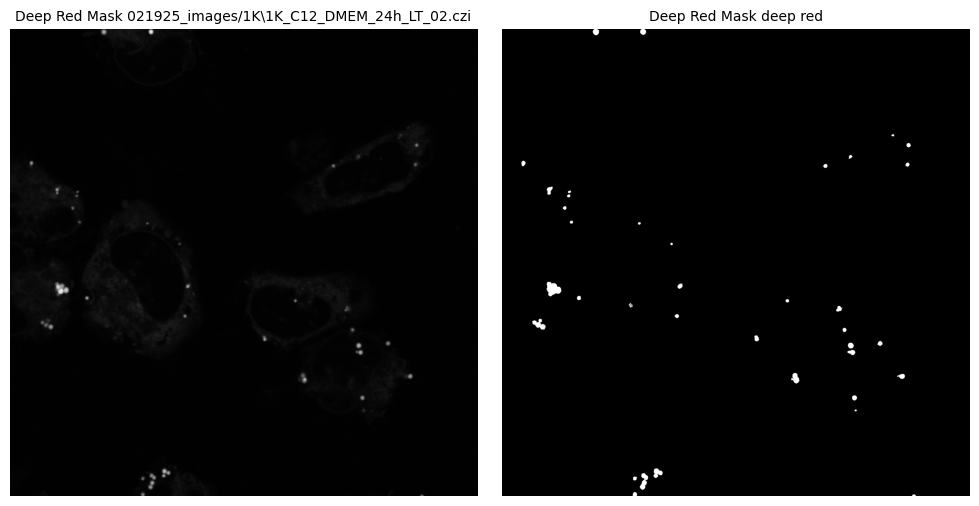

    Processing 021925_images/1K\1K_C12_DMEM_24h_LT_03.czi…


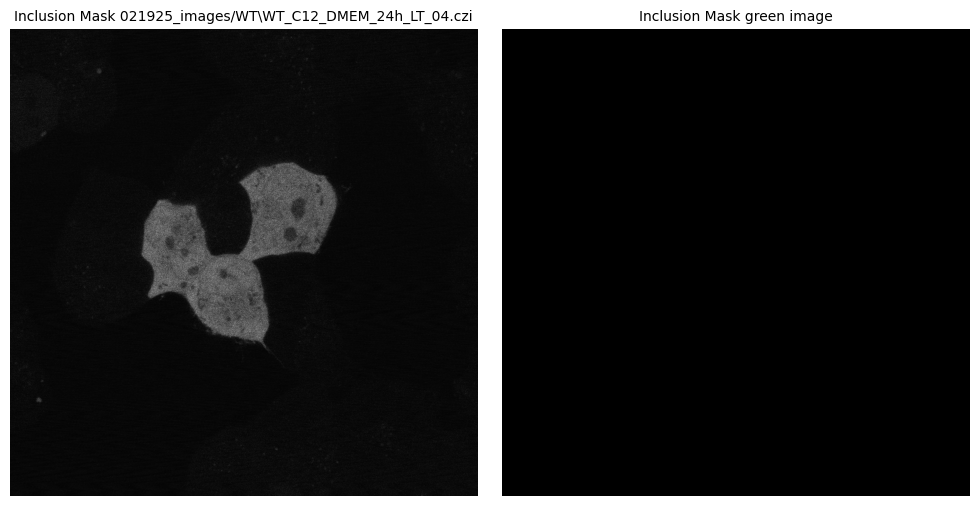

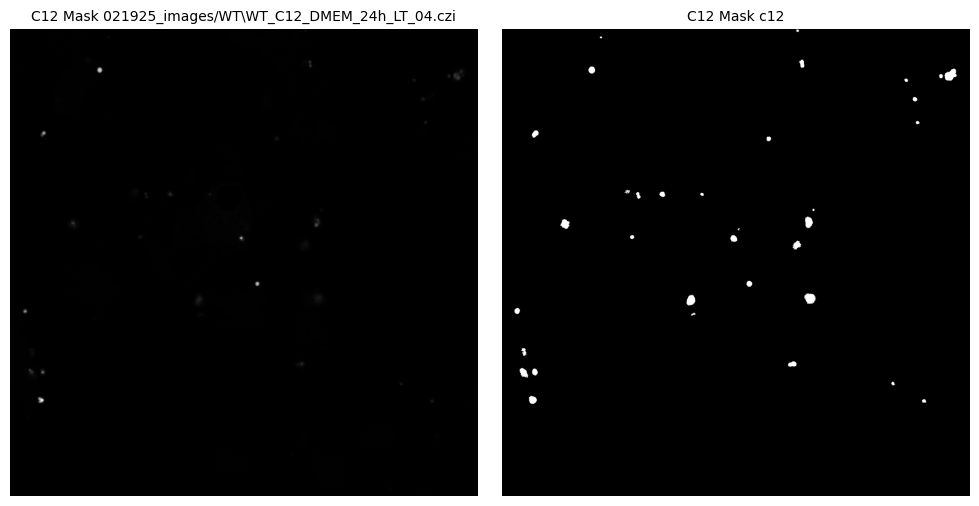

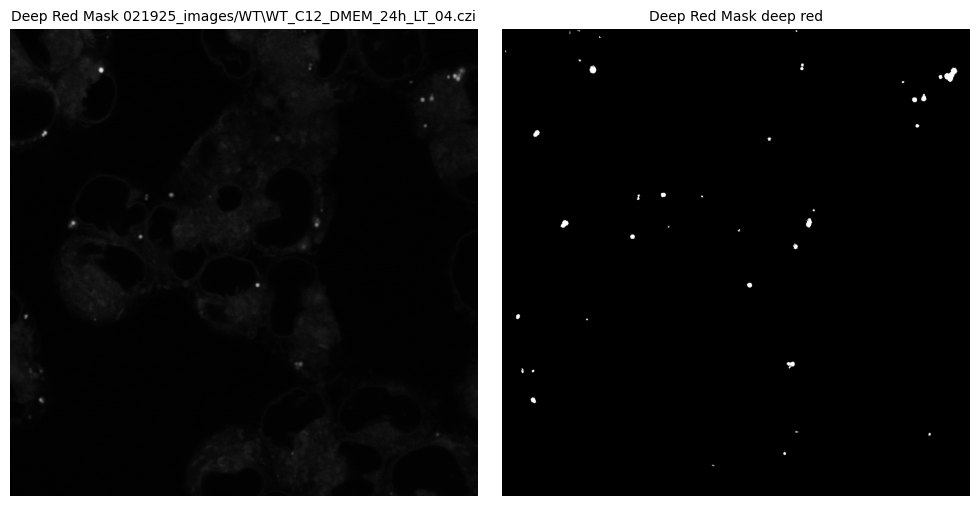

    Processing 021925_images/WT\WT_C12_DMEM_24h_LT_05.czi…


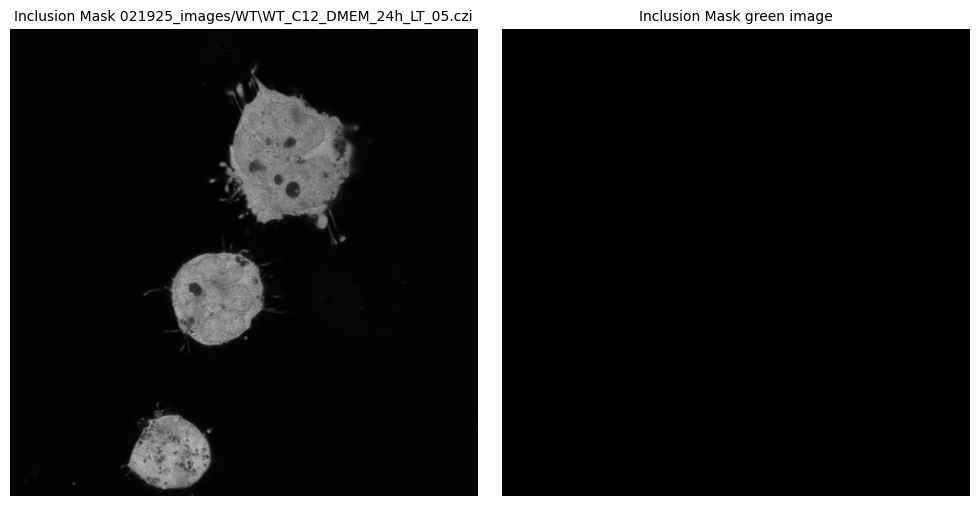

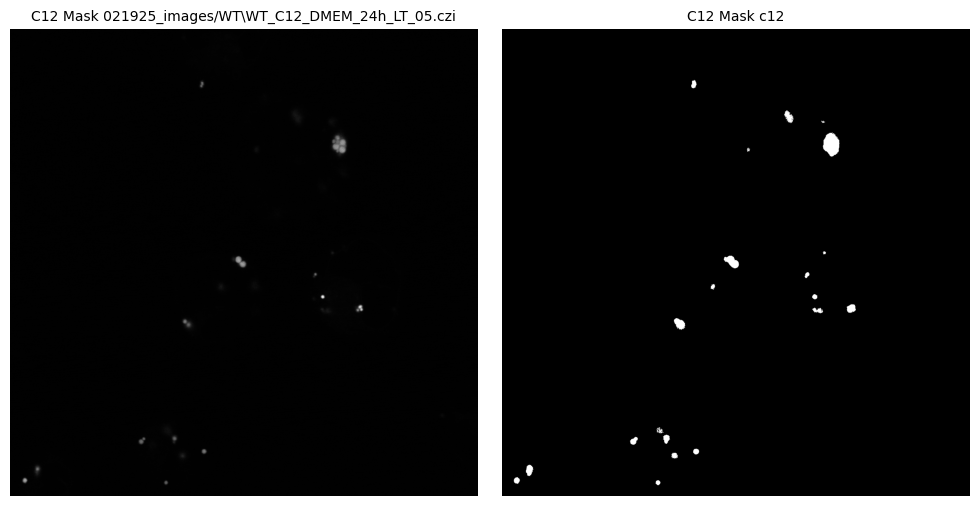

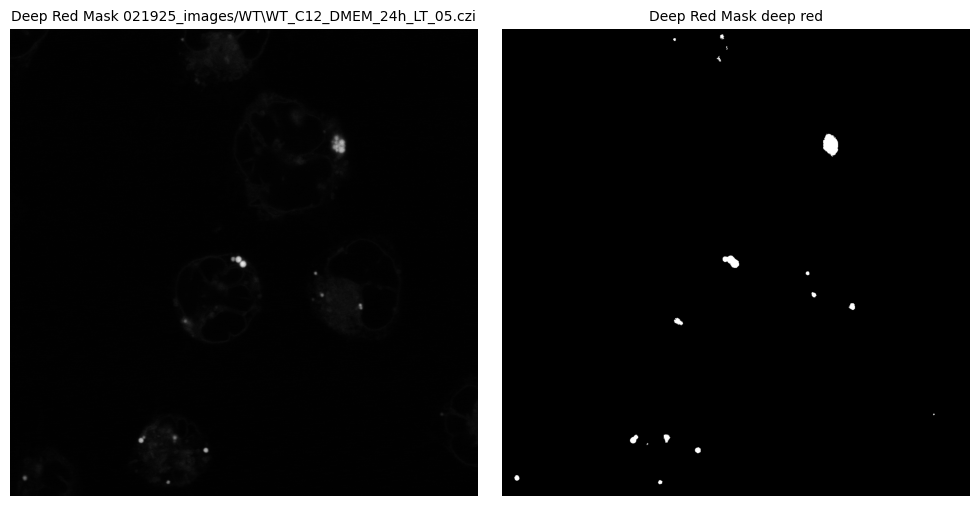

    Processing 021925_images/WT\WT_C12_DMEM_24h_LT_06.czi…


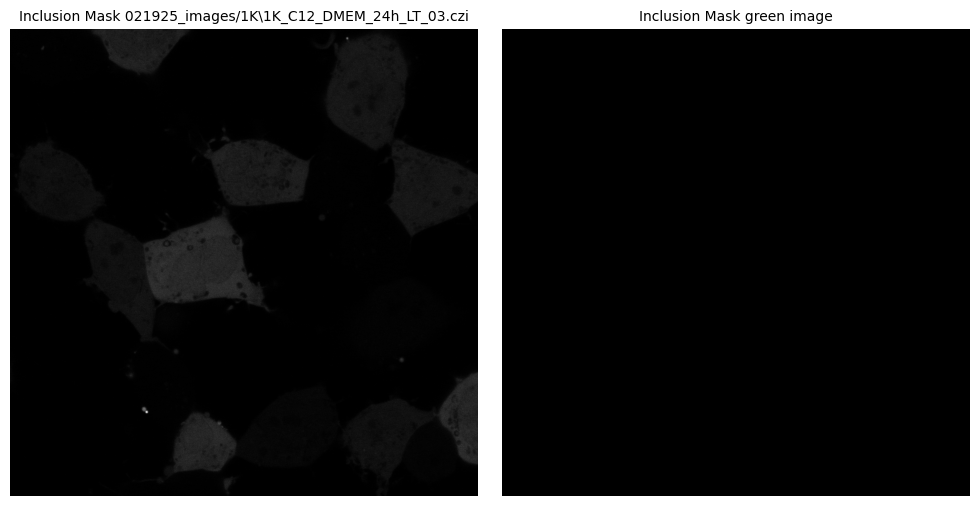

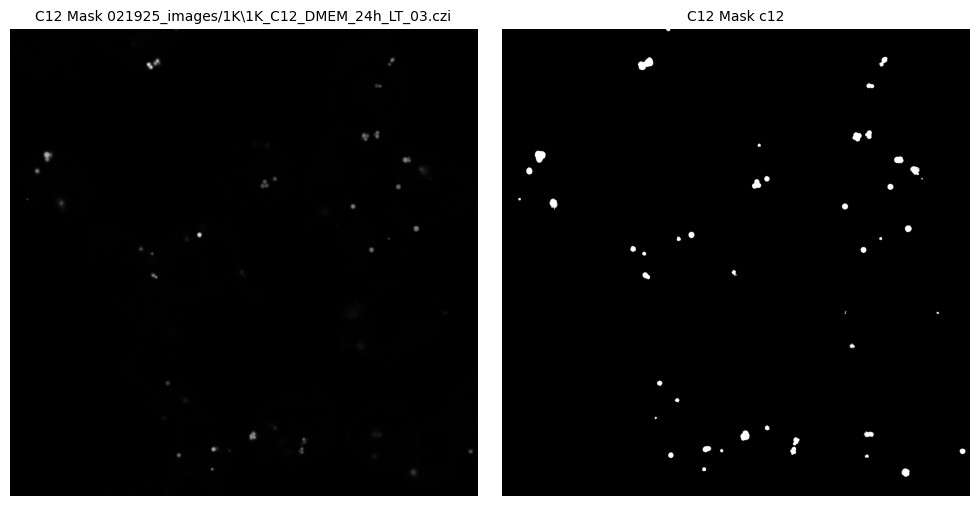

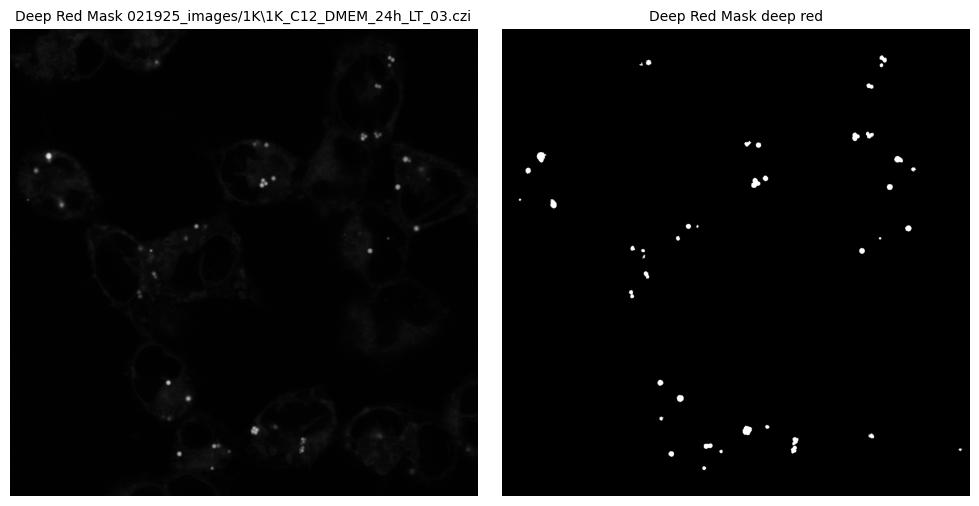

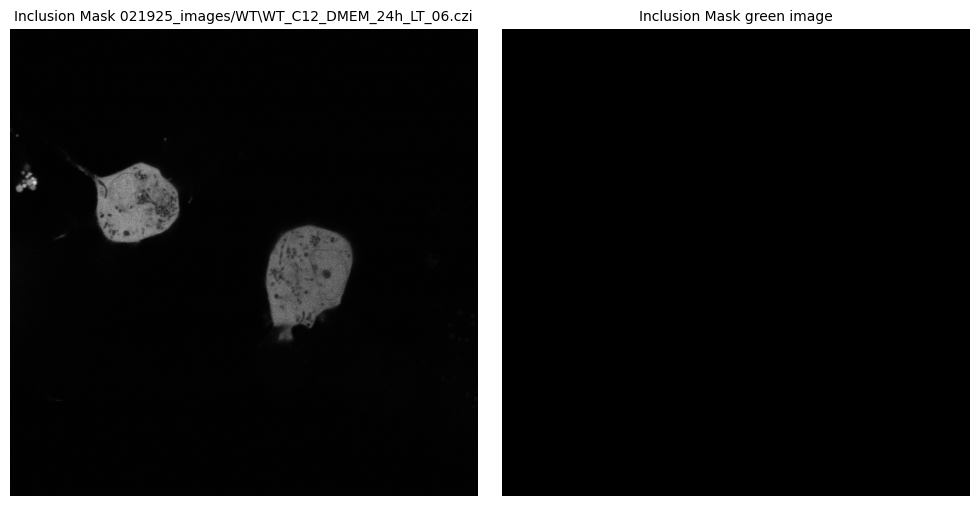

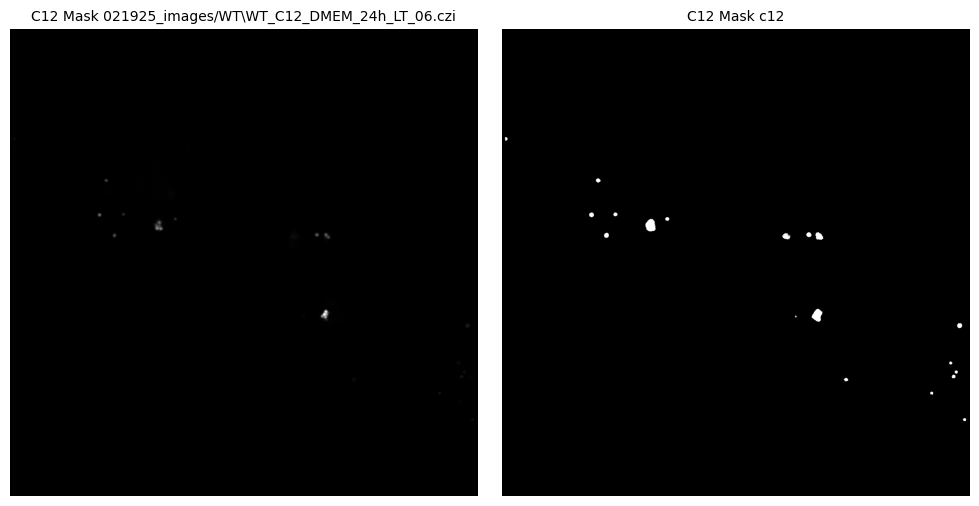

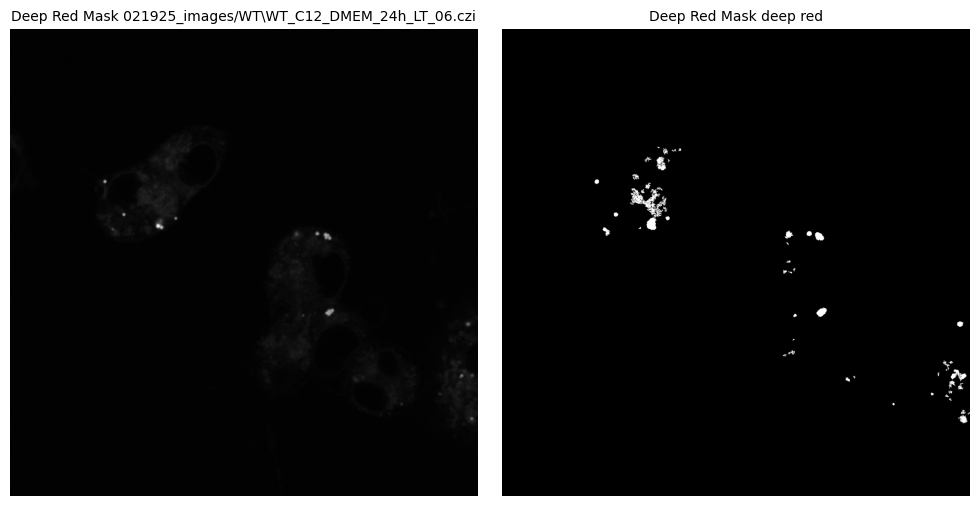

    Processing 021925_images/WT\WT_C12_DMEM_6h_LT_01.czi…
    Processing 021925_images/1K\1K_C12_DMEM_24h_LT_04.czi…


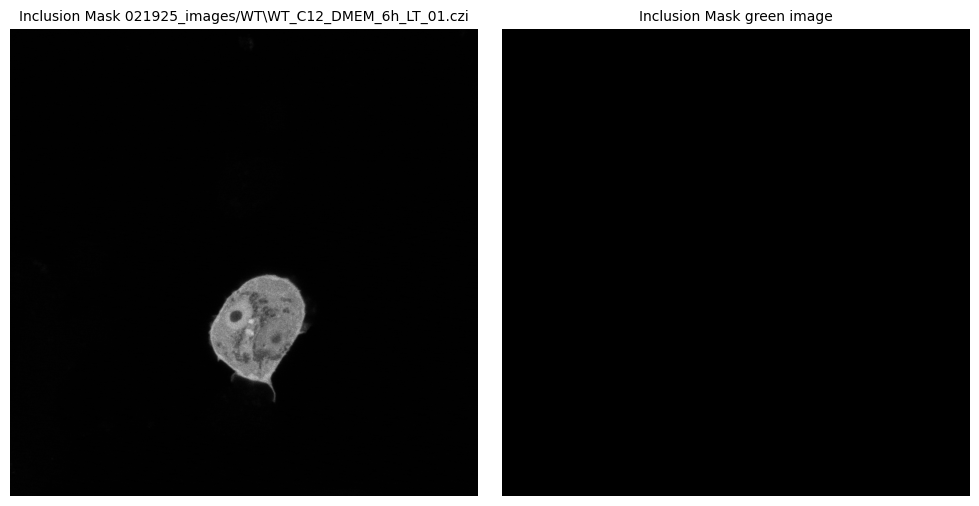

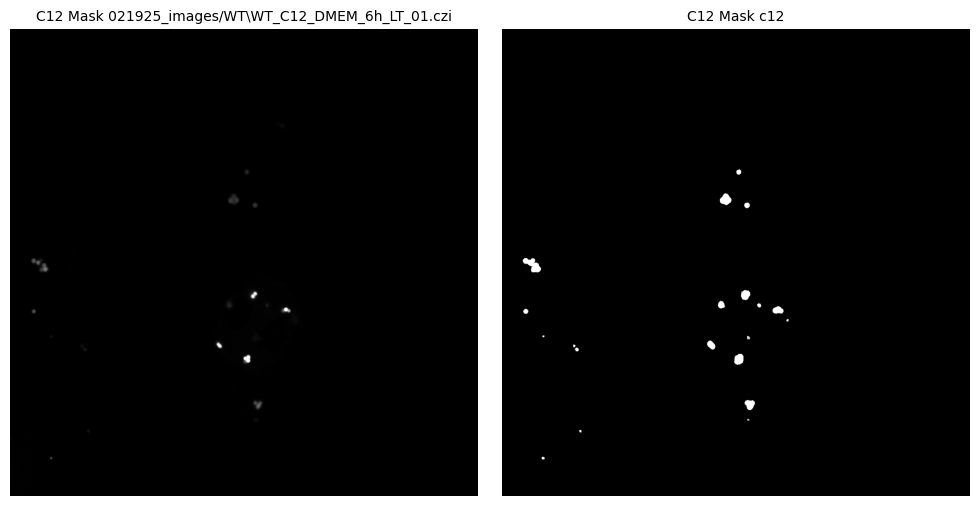

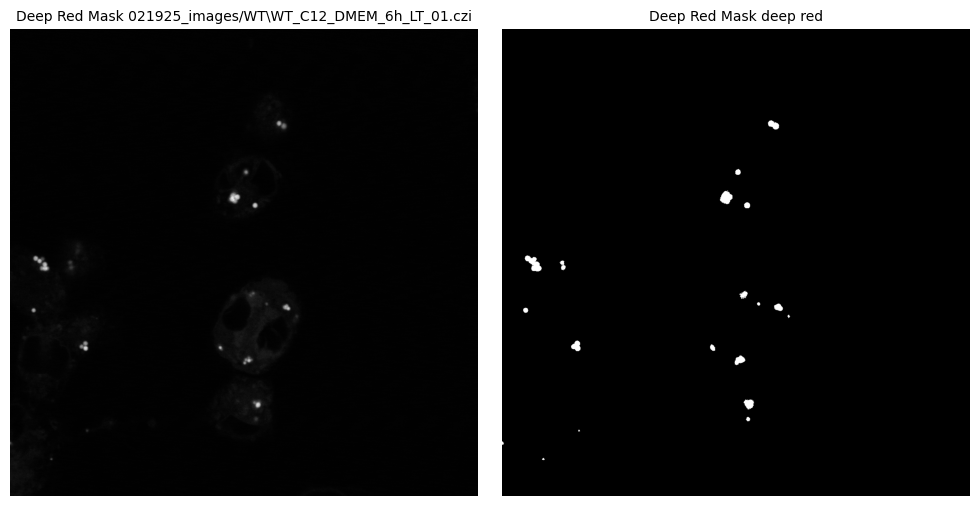

    Processing 021925_images/WT\WT_C12_DMEM_6h_LT_02.czi…


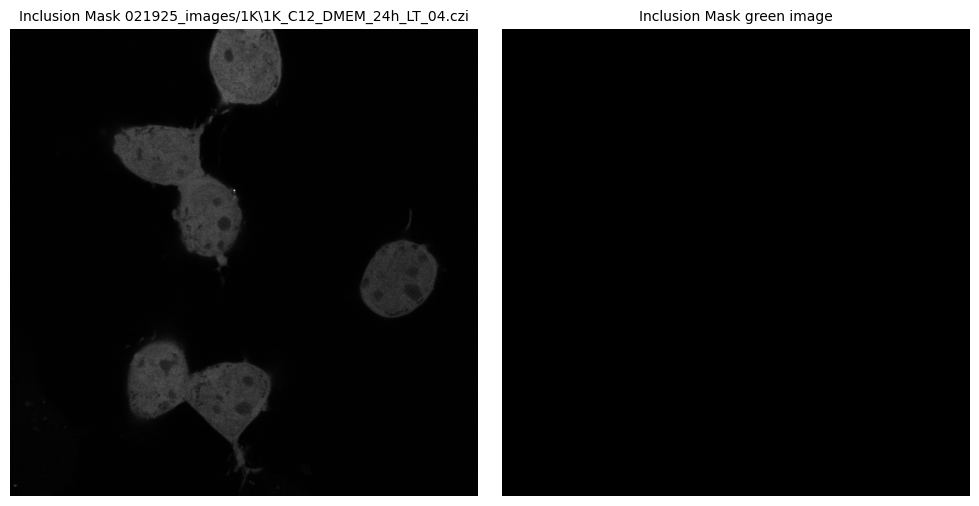

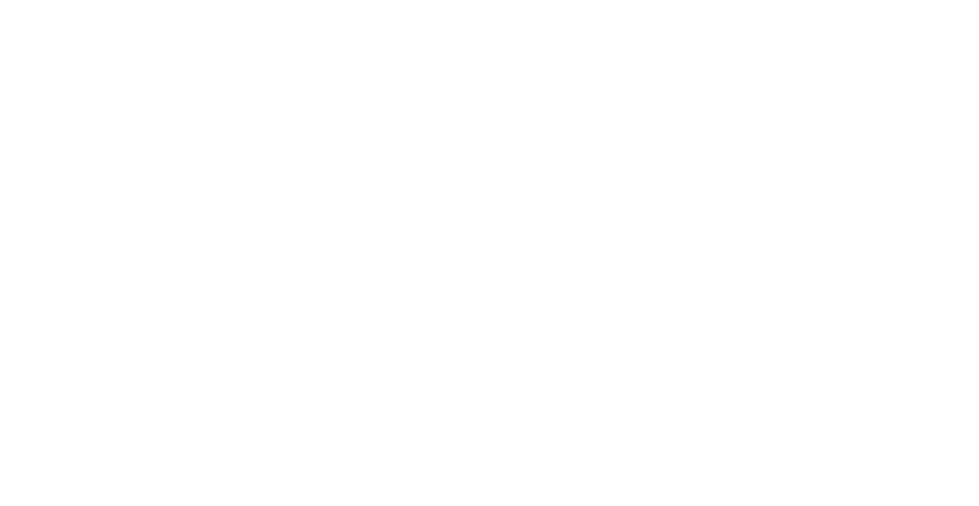

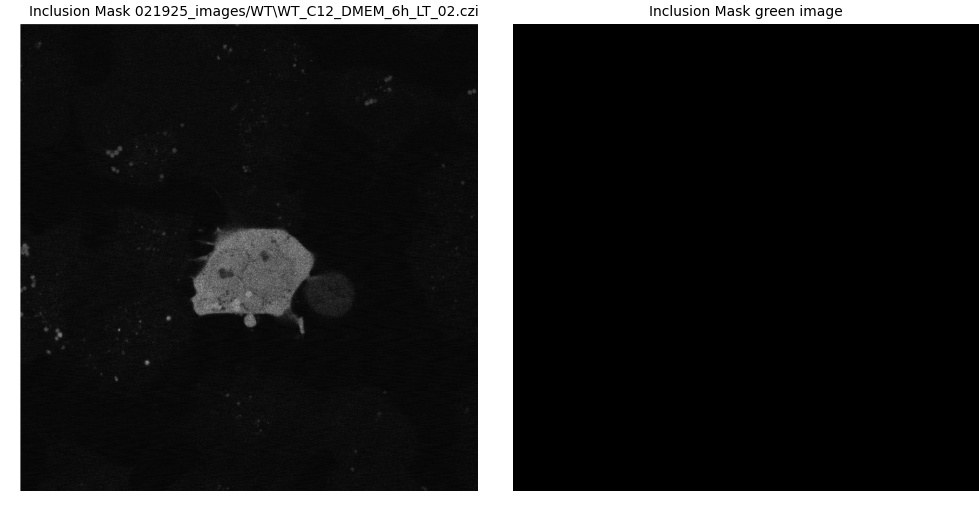

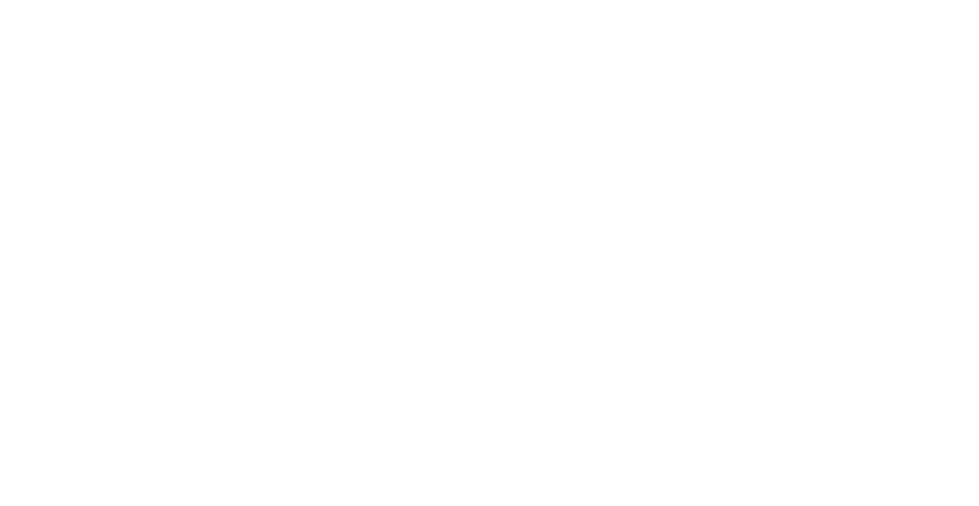

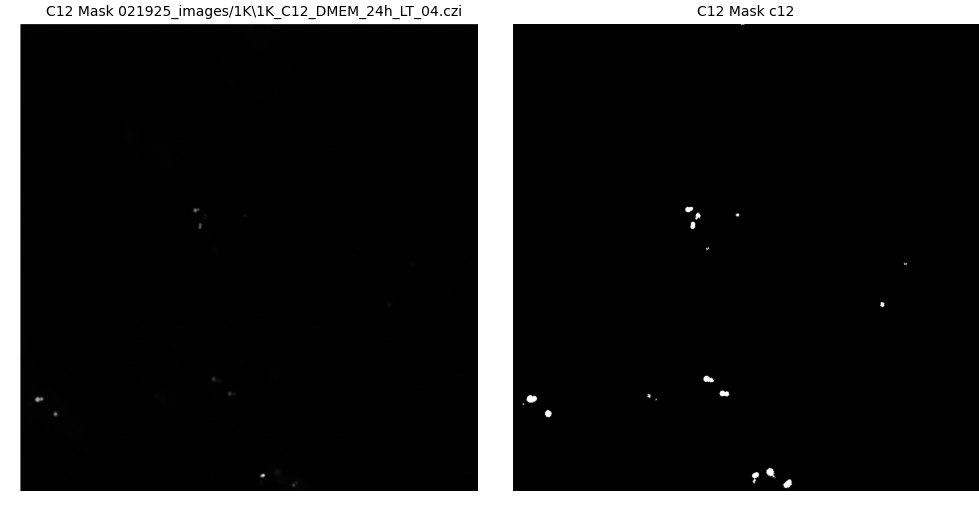

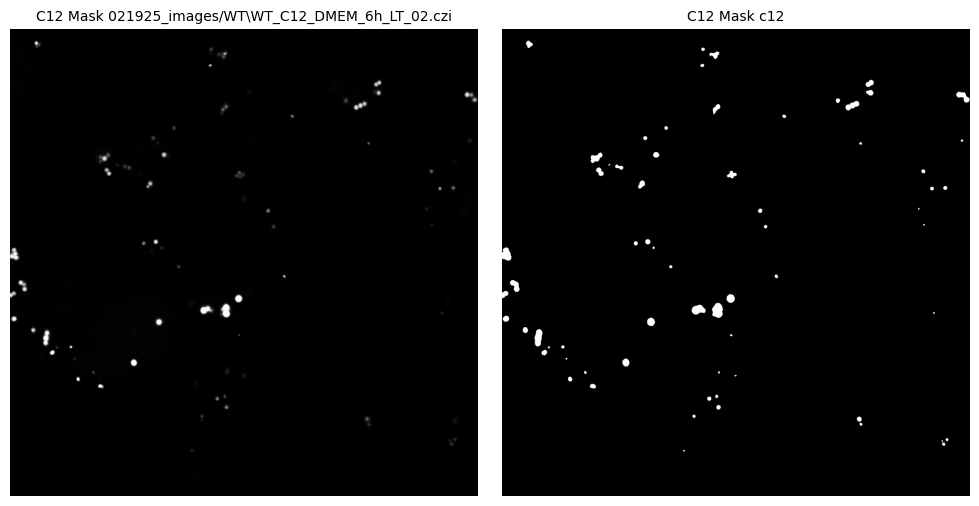

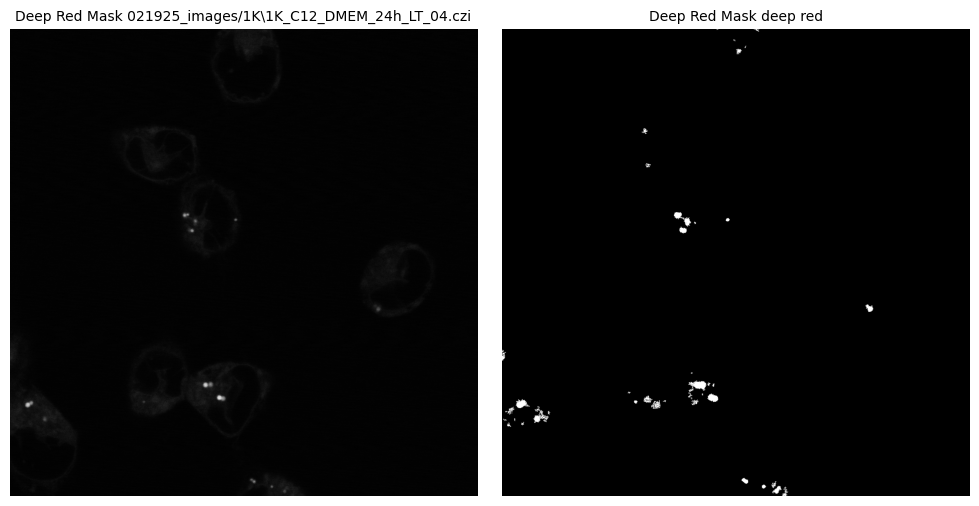

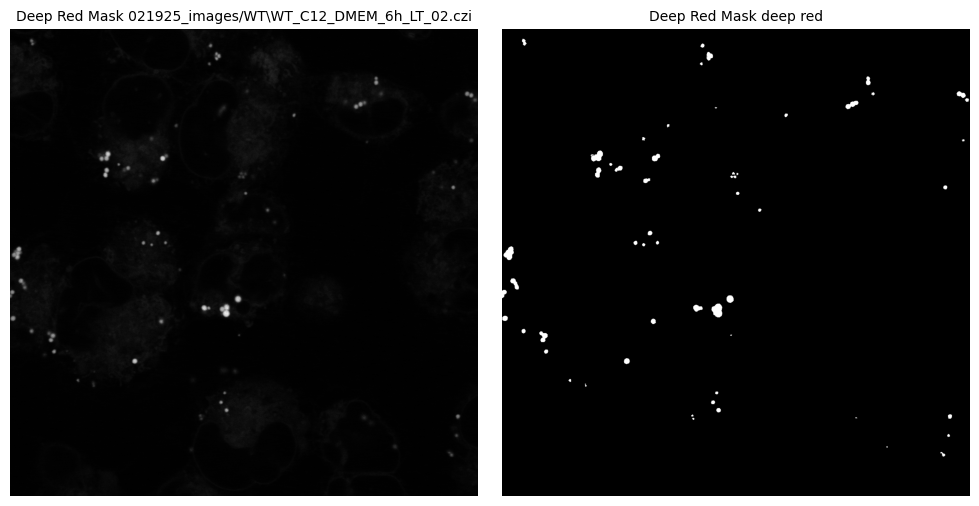

    Processing 021925_images/WT\WT_C12_DMEM_6h_LT_03.czi…
    Processing 021925_images/1K\1K_C12_DMEM_24h_LT_05.czi…


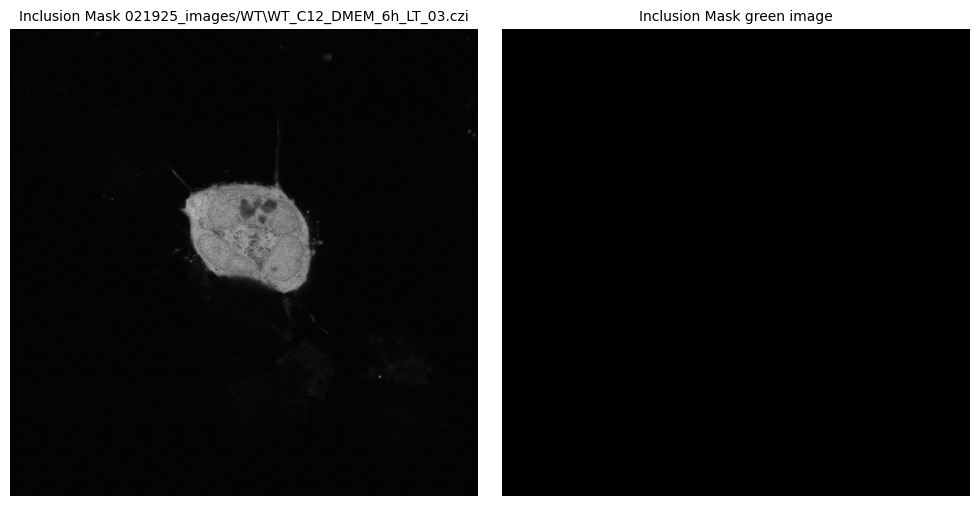

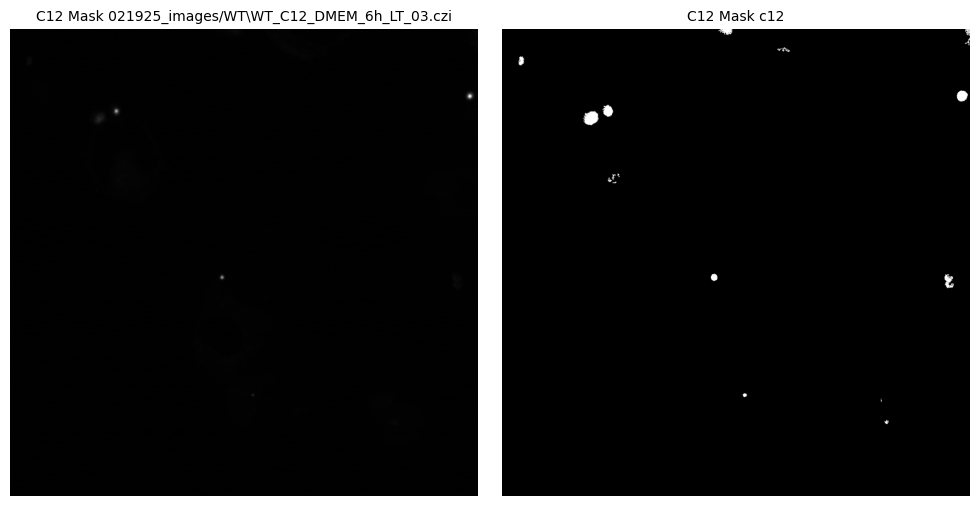

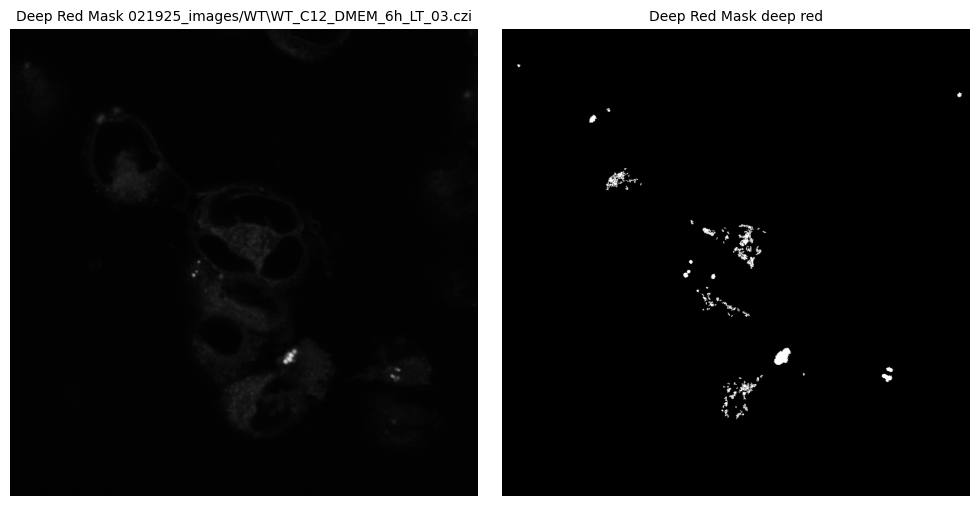

    Processing 021925_images/WT\WT_C12_DMEM_6h_LT_04.czi…


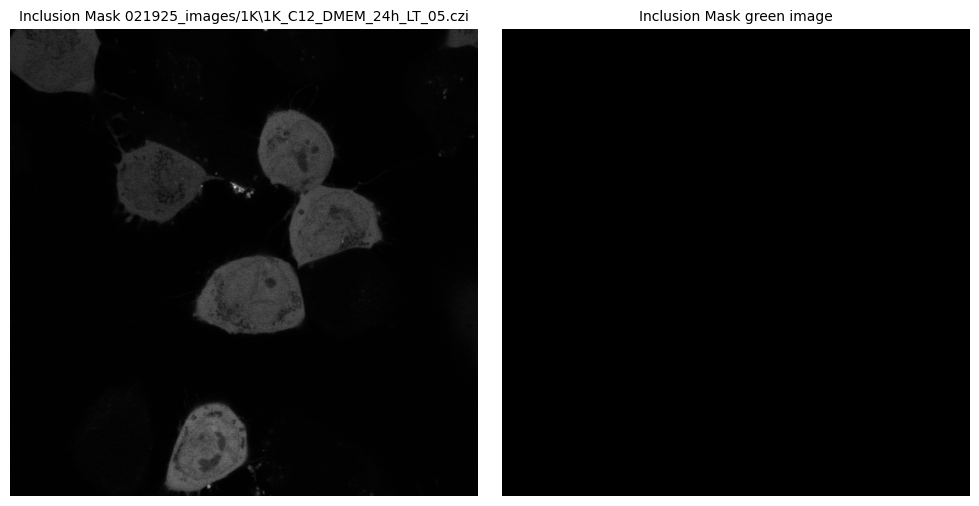

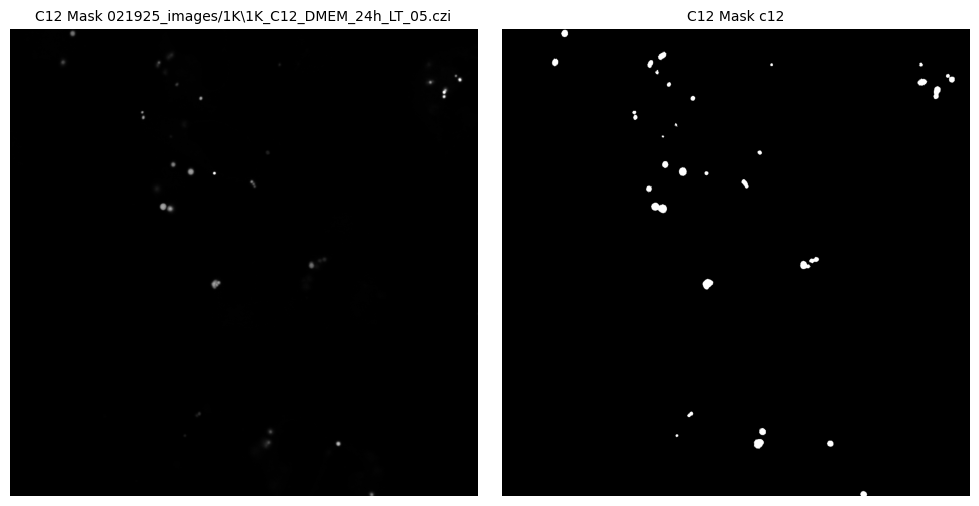

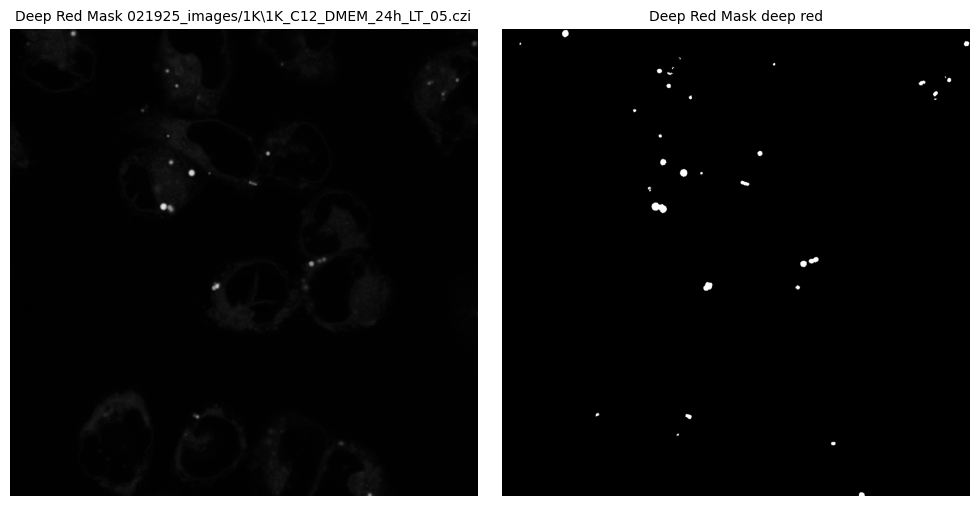

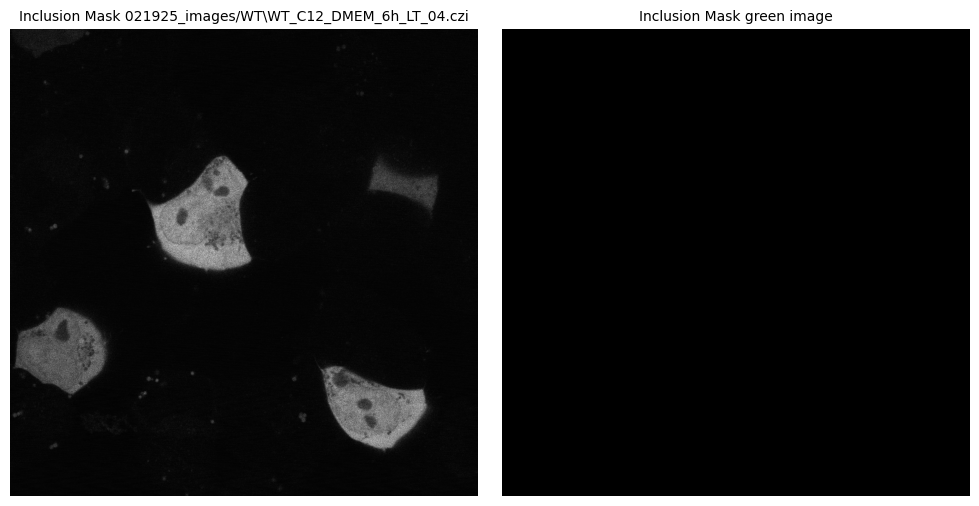

    Processing 021925_images/1K\1K_C12_DMEM_24h_LT_06.czi…


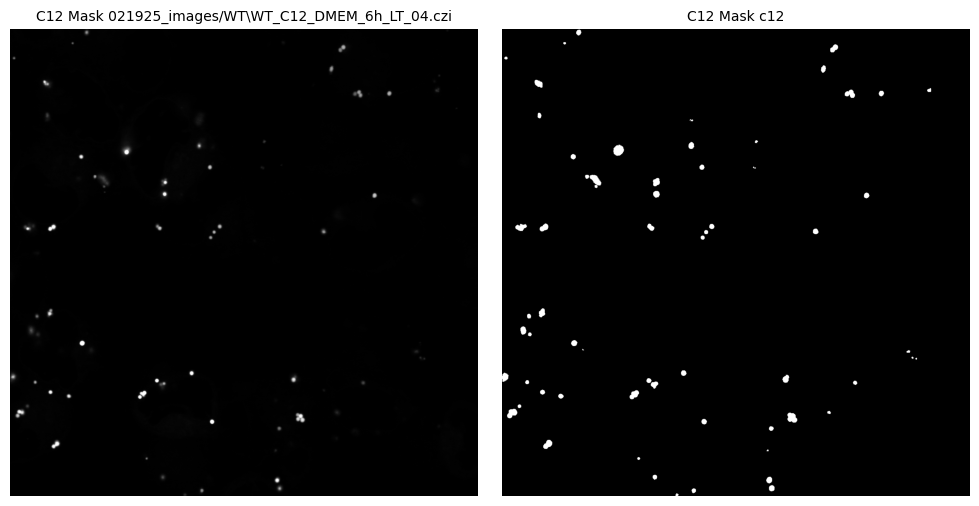

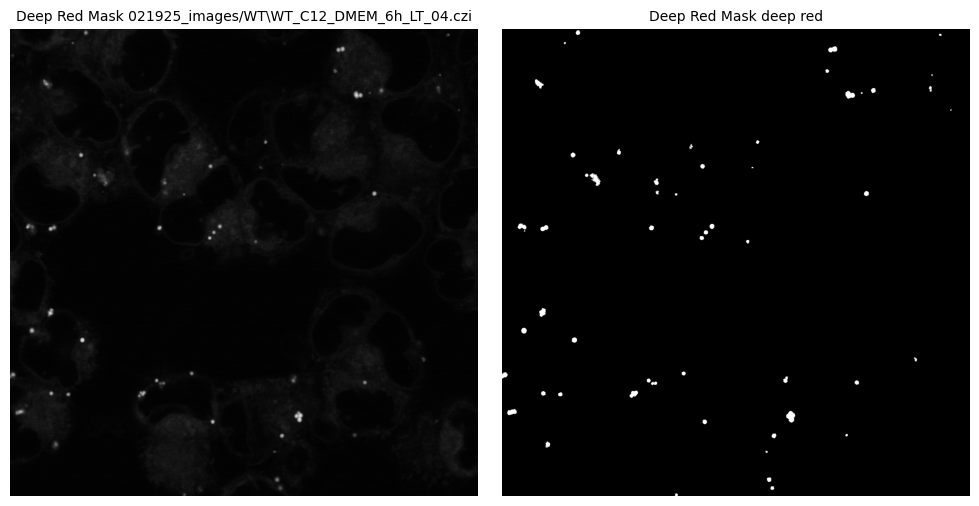

    Processing 021925_images/WT\WT_C12_DMEM_6h_LT_05.czi…


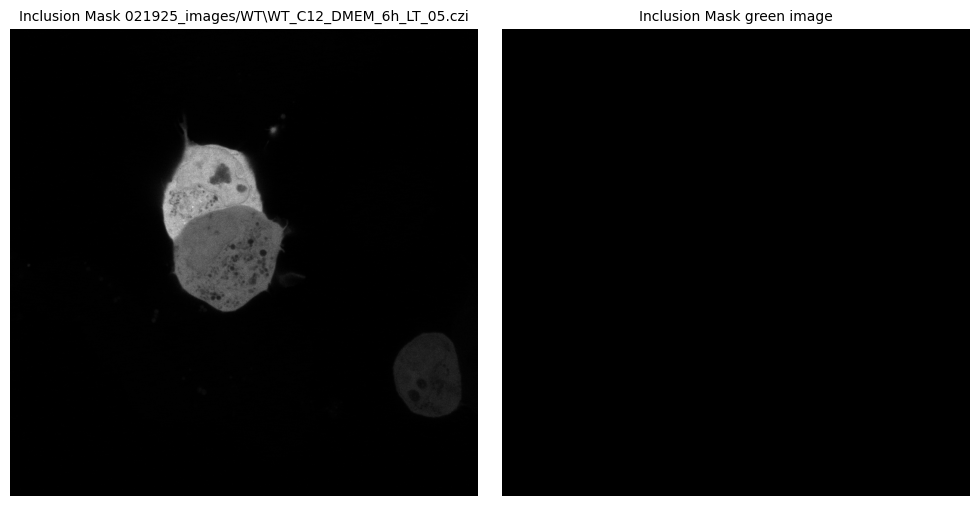

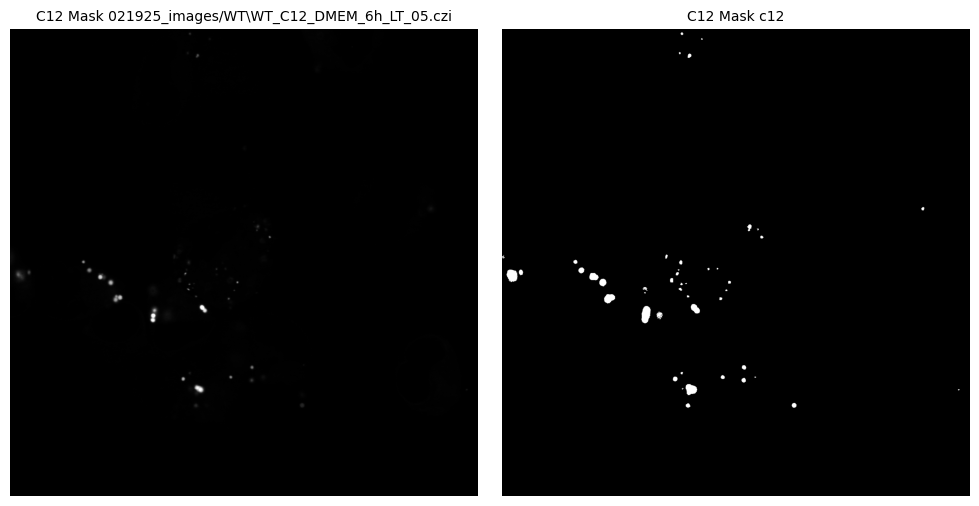

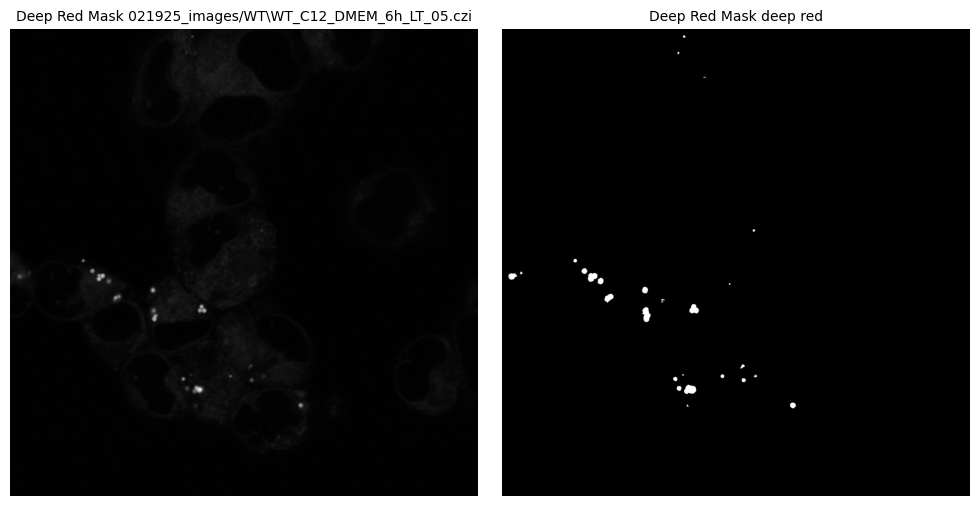

    Processing 021925_images/WT\WT_C12_DMEM_6h_LT_06.czi…


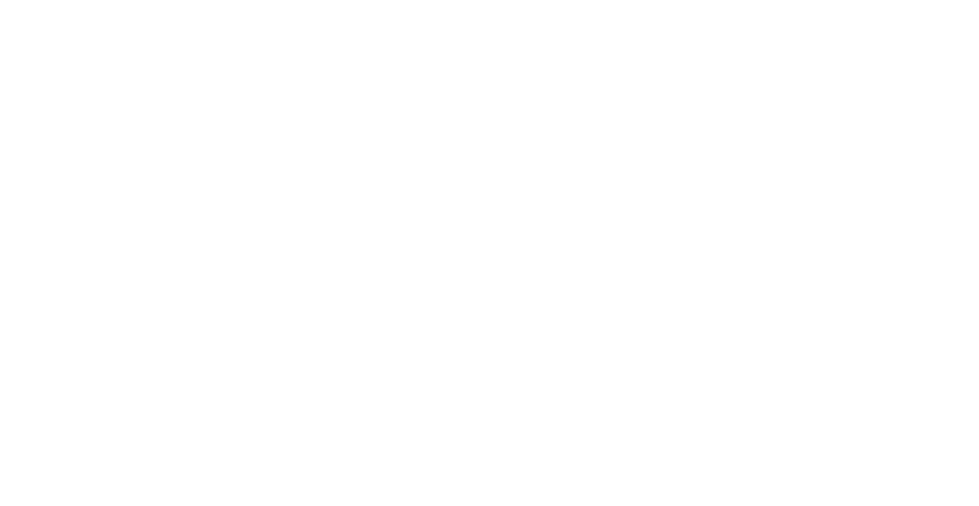

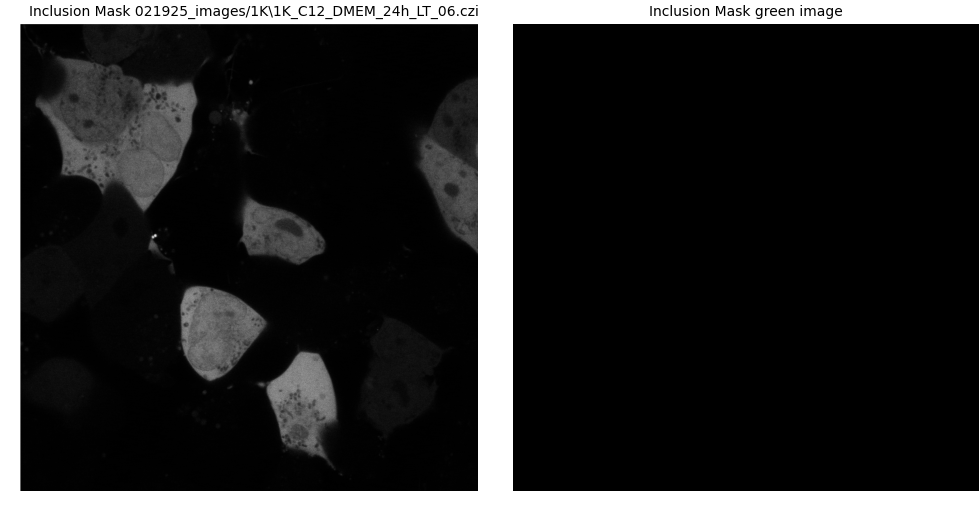

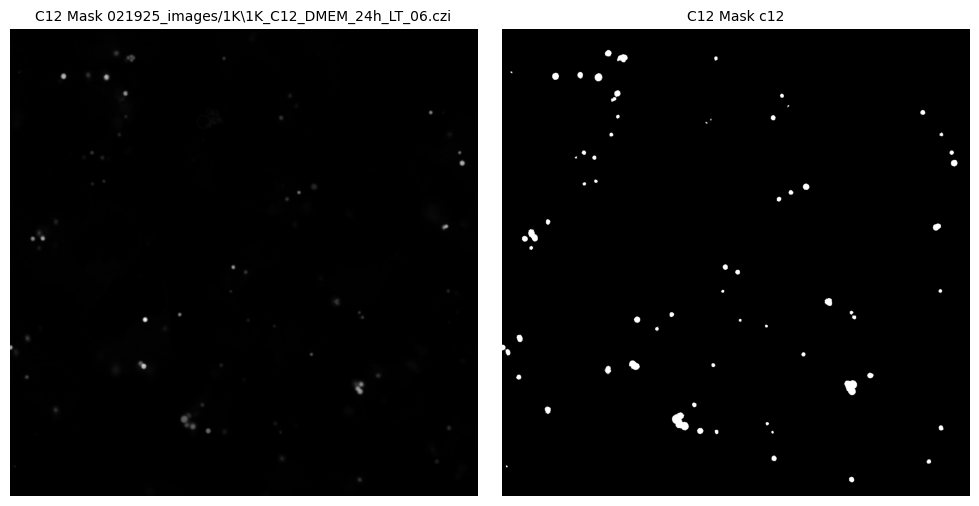

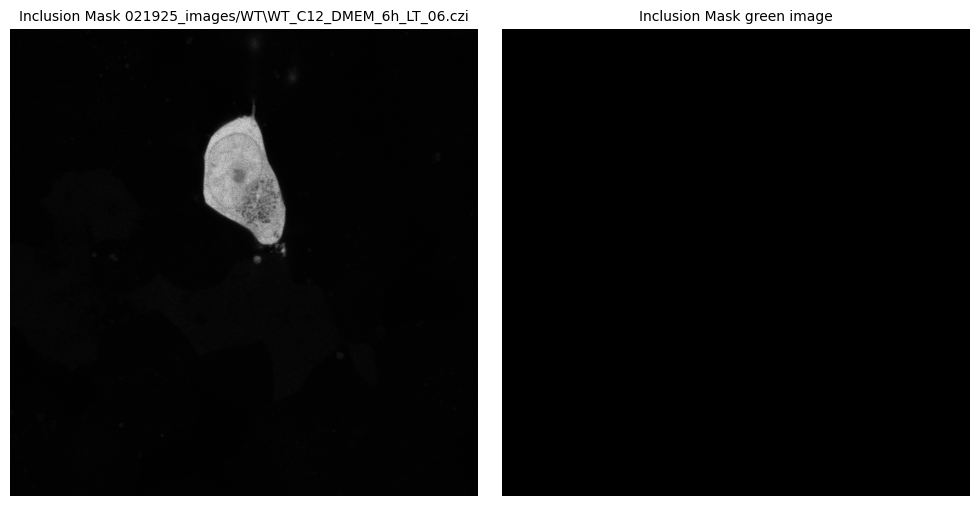

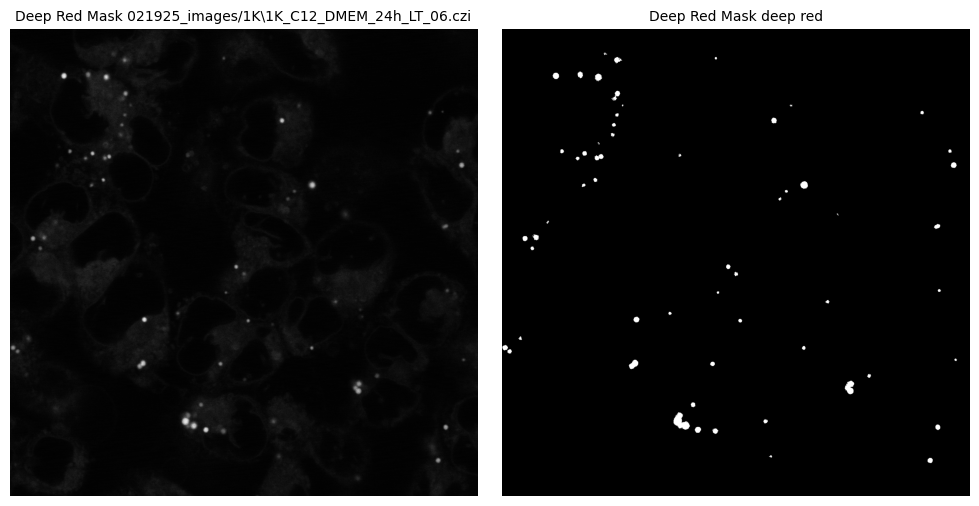

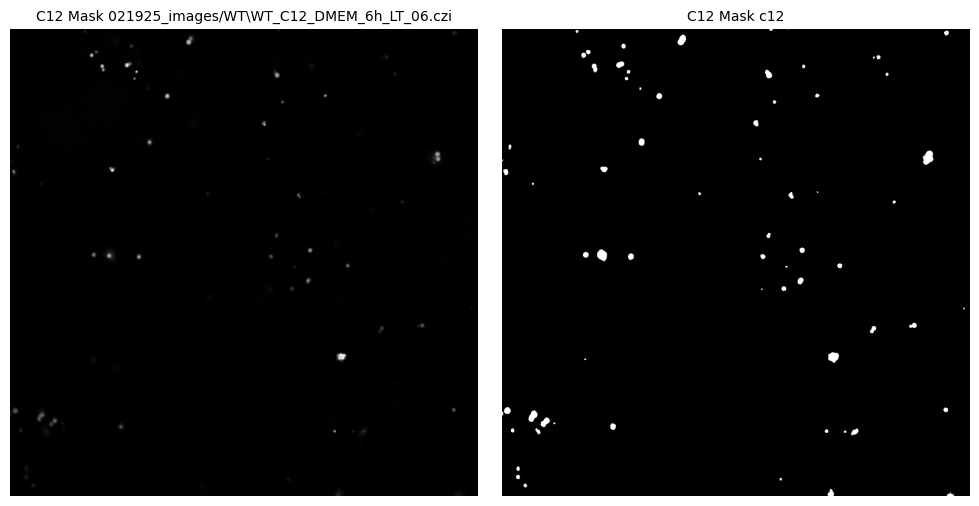

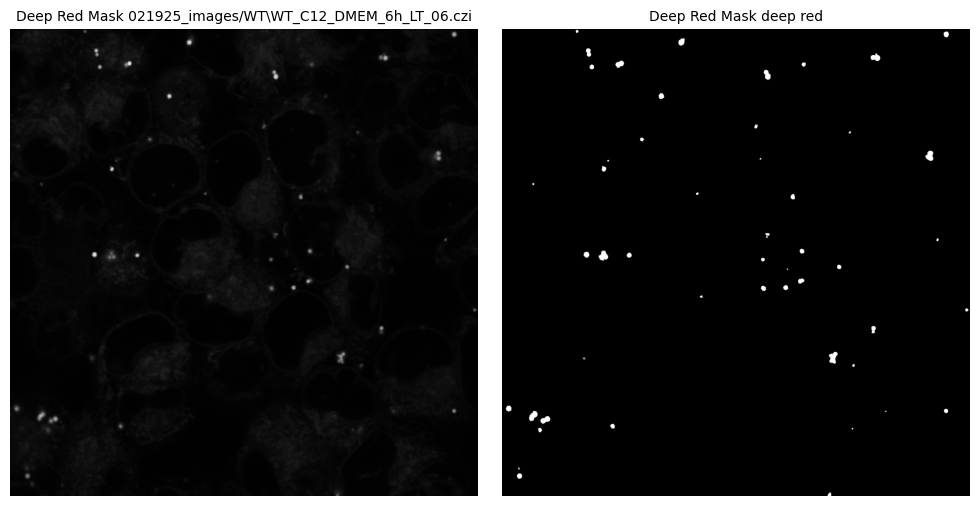

    Processing 021925_images/WT\WT_C12_HBSS_24h_LT_01.czi…
    Processing 021925_images/1K\1K_C12_DMEM_6h_LT_01.czi…


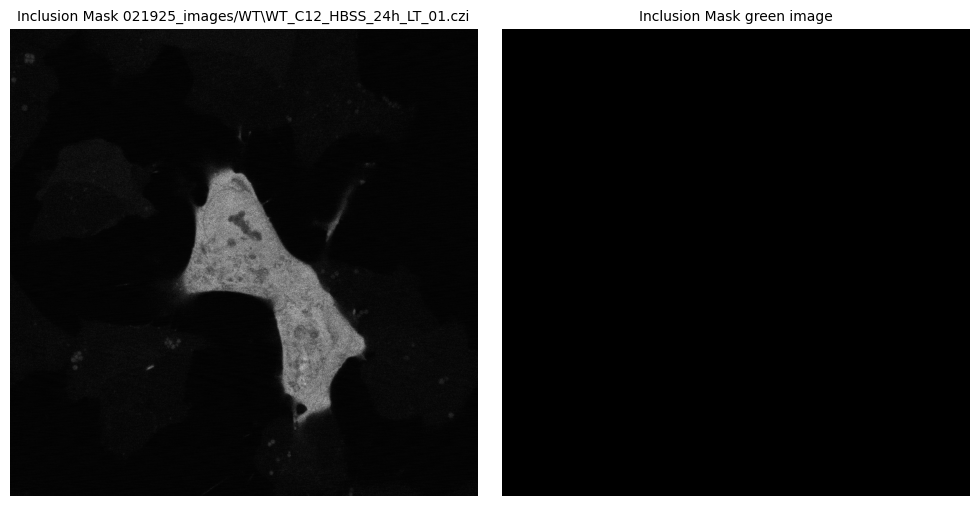

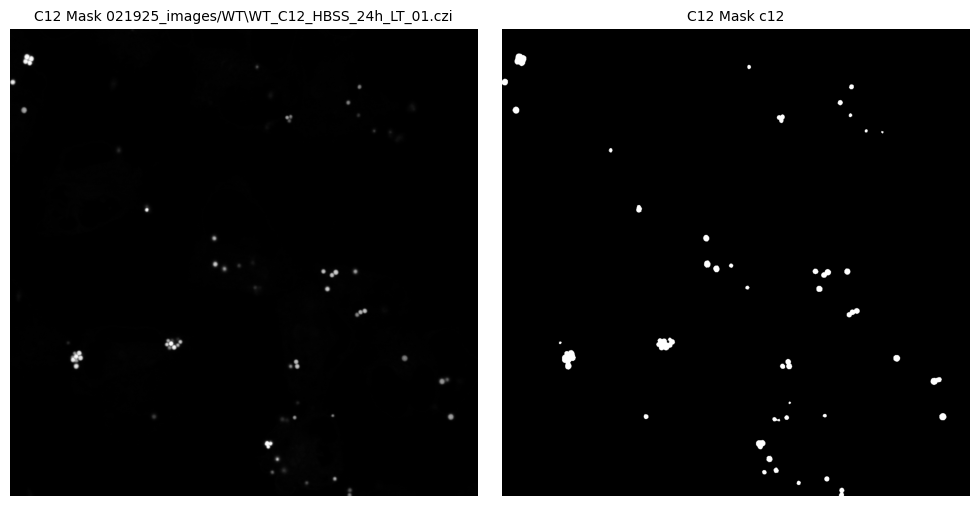

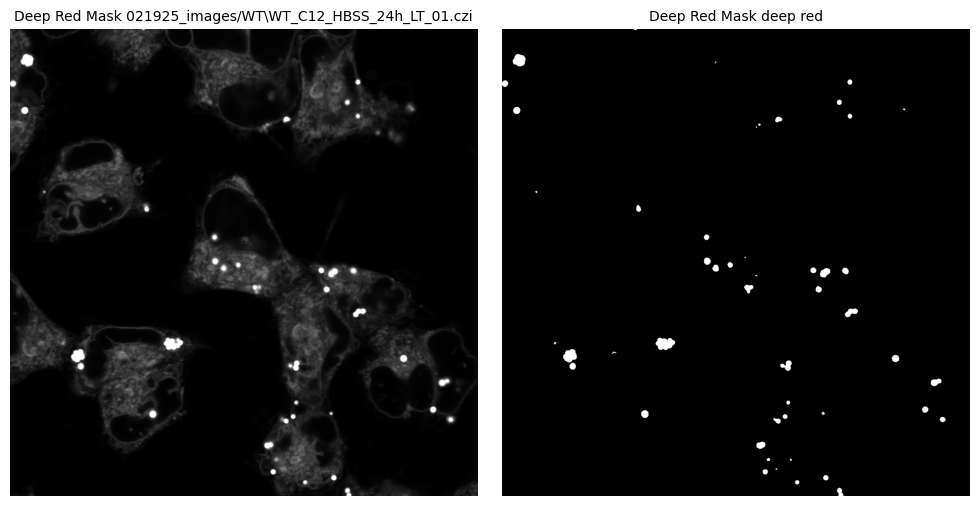

    Processing 021925_images/WT\WT_C12_HBSS_24h_LT_02.czi…


In [ ]:
def process_folder(image_folder):
    print(f"→ Starting {image_folder}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    images_to_analyze = extract_image_paths(image_folder)
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=MODEL_TYPE,
        checkpoint=CHECKPOINT,
        device=device,
        is_tiled=False,
    )

    df_list = []
    for path in images_to_analyze:
        print(f"    Processing {path}…")
        image = read_image(path)
        image_squeezed = np.squeeze(image)

        deep_red, c12, green_channel = extract_channels(image_squeezed)
        preprocessed_green = preprocess_green_channel(green_channel)
        labeled_cells = segment_cells(preprocessed_green)

        if 'OA_24h_LT_' in path:
            inclusion_mask = (
                automatic_instance_segmentation(
                    predictor=predictor,
                    segmenter=segmenter,
                    input_path=green_channel,
                    ndim=2,
                ) > 0
            )
        else:
            inclusion_mask = np.zeros_like(green_channel, dtype=bool)

        display_two_images(green_channel, inclusion_mask, path, "green image", "Inclusion Mask")

        c12_mask = analyze_image_c12(c12)
        deep_red_mask = analyze_image_deep_red(deep_red)

        display_two_images(c12, c12_mask, path, "c12","C12 Mask")
        display_two_images(deep_red, deep_red_mask, path, "deep red", "Deep Red Mask")
        deep_red_only, c12_only = separate_touching_objects(deep_red_mask, c12_mask, path)

        df = analysis(
            labeled_cells,
            path,
            deep_red_mask,
            c12_mask,
            deep_red_only,
            c12_only,
            inclusion_mask
        )
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)

    # ─ naming for nested folders like '012925_images/1K' → '012925_1k_SUMMARY.xlsx'
    parent_base = os.path.basename(os.path.dirname(image_folder.rstrip("/\\")))
    parent_id = parent_base[:-7] if parent_base.endswith("_images") else parent_base
    child_base  = os.path.basename(image_folder.rstrip("/\\")).lower()

    out_name = f"{parent_id}_{child_base}_SUMMARY.xlsx"
    out_path = os.path.join(os.getcwd(), out_name)
    combined_df.to_excel(out_path, index=False)

    print(f"✓ Finished {image_folder} → {out_path}")
    return out_path


def main():
    folders = [
        '021925_images/1K',
        '021925_images/WT',

    ]

    # now use threads safely
    with ThreadPoolExecutor(max_workers=len(folders)) as executor:
        futures = {executor.submit(process_folder, f): f for f in folders}
        for fut in as_completed(futures):
            folder = futures[fut]
            try:
                fut.result()
            except Exception as e:
                print(f"✗ Error processing {folder}: {e}")


if __name__ == "__main__":
    main()